In [36]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import log
import ultranest
from ultranest.plot import cornerplot
from scipy.stats import poisson
import pandas as pd
import healpy as hp
from healpy.newvisufunc import projview, newprojplot
import astropy.units as u
from matplotlib import colors as mcolors
from ultranest.utils import resample_equal
from scipy.interpolate import interp1d
import scipy.stats as stats
import ultranest.stepsampler
import itertools
import gc
import json
import corner
import os
from matplotlib.lines import Line2D

In [37]:
# Import functions
from my_functions import *

In [38]:
def process_vector_component(l, b, nside, smooth_sigma):
        pixels = hp.ang2pix(nside, b, l, nest=False)
        healpix_map = np.bincount(pixels, minlength=hp.nside2npix(nside)).astype(np.float64)
        healpix_map /= healpix_map.sum()
        smoothed_map = hp.sphtfunc.smoothing(healpix_map, sigma=smooth_sigma)
        smoothed_map[smoothed_map < 0] = 0
        smoothed_map /= smoothed_map.sum()
        return smoothed_map
        

def get_projection_and_contours(hmap, contour_levels=[0.5, 1, 1.5, 2]):
        X, Y, proj_map = hp.projview(hmap, return_only_data=True, xsize=100, cbar=False)
        P_xy = proj_map / proj_map.sum()
        t_contours, P_levels, P_integral = compute_2D_contours(P_xy, contour_levels)
        return X, Y, P_xy, t_contours


In [39]:
def mask_data(NSIDE, m, mask_angle):
    NPIX = hp.nside2npix(NSIDE)
    theta, phi = hp.pix2ang(NSIDE, np.arange(NPIX))
    mask = (theta > np.radians(90 - mask_angle)) & (theta < np.radians(90+mask_angle))
    
    # for plotting
    m_plot = hp.ma(m.copy().astype(float))
    m_plot.mask = mask

    # for fitting, can't use nans need to remove the masked indices. Also need fit_mask to mask in likelihood too
    m_fit = m.copy()
    fit_mask = ~mask
    m_fit = m[fit_mask]

    return m_plot, m_fit, fit_mask

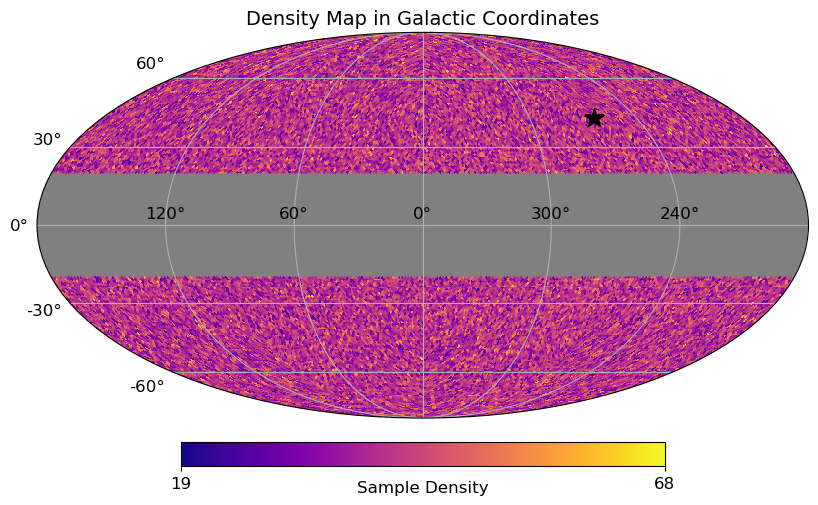

In [5]:
NSIDE=64
npix = hp.nside2npix(NSIDE)
dipole_theta = np.radians(48)
dipole_phi = -np.radians(96)
m, lambdas = dipole_sampling(NSIDE, 40, 0.007, dipole_theta, dipole_phi)


theta, phi = hp.pix2ang(NSIDE, np.arange(npix))

mask_angle = 20 
m_plot_masked, m_fit, fit_mask = mask_data(NSIDE, m, mask_angle)
mask = (theta >= np.radians(90 - mask_angle)) & (theta <= np.radians(90+mask_angle))

# # for plotting, need to use nans
m_plot_masked = hp.ma(m.copy().astype(float))
m_plot_masked.mask = mask

# Set the masked values to be gray for plotting
cmap = plt.get_cmap('plasma').copy()
cmap.set_bad('gray')

# for fitting, can't use nans need to remove the masked indices. Also need fit_mask to mask in likelihood too
m_fit = m.copy()
fit_mask = ~mask
m_fit = m[fit_mask] 


dipole_plotting(m_plot_masked, dipole_theta, dipole_phi,
                        title='Density Map in Galactic Coordinates', unit="Sample Density",
                        cmap=cmap)


plt.show()


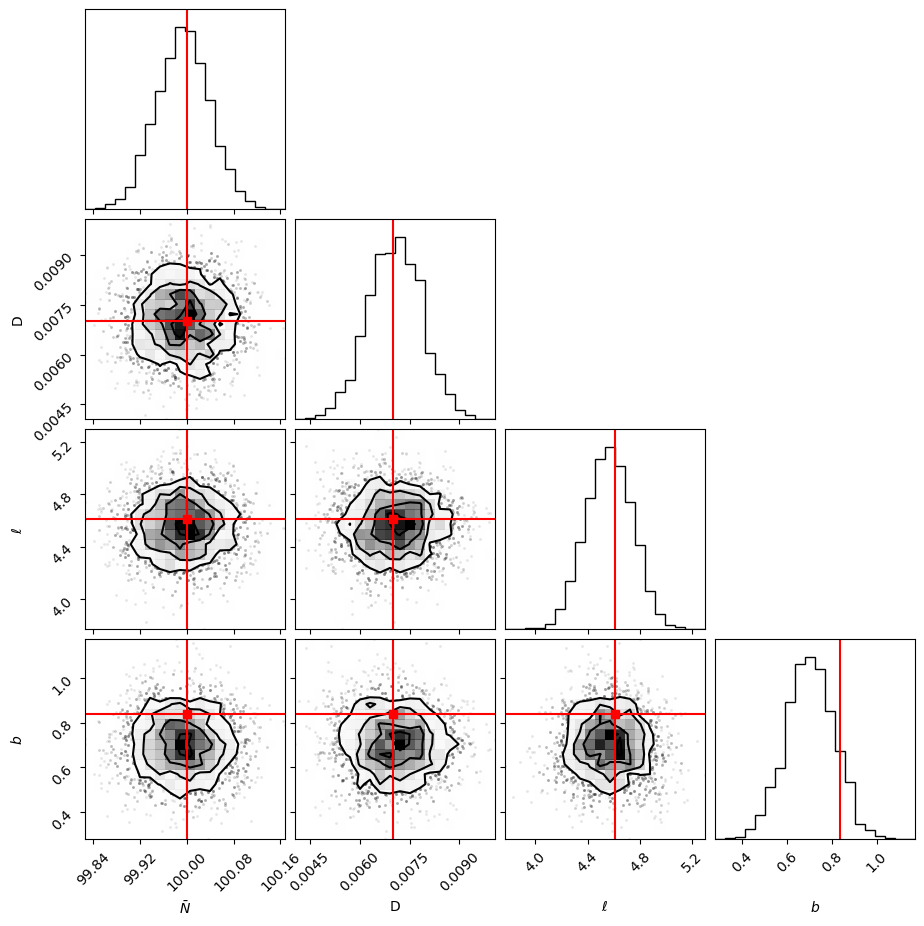

KeyboardInterrupt: 

<Figure size 400x400 with 0 Axes>

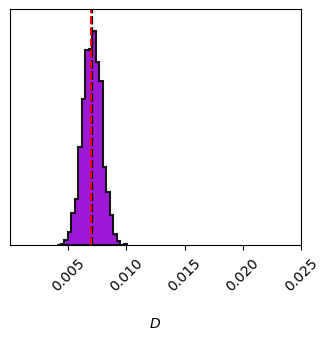

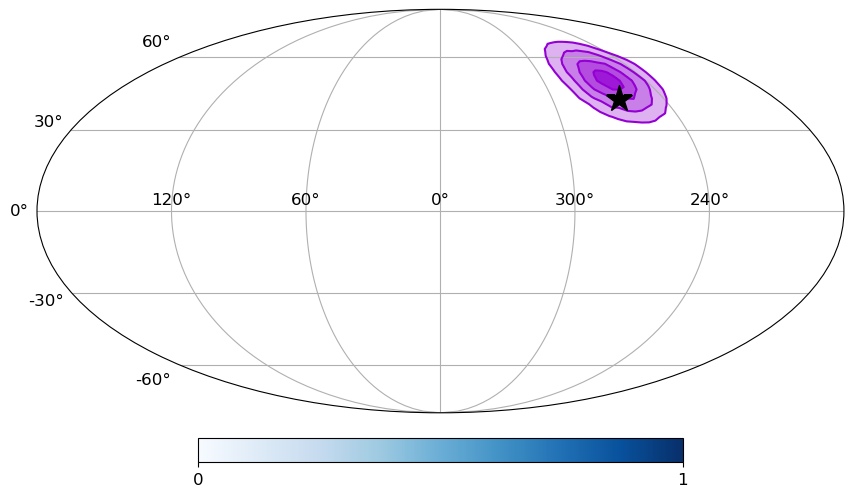

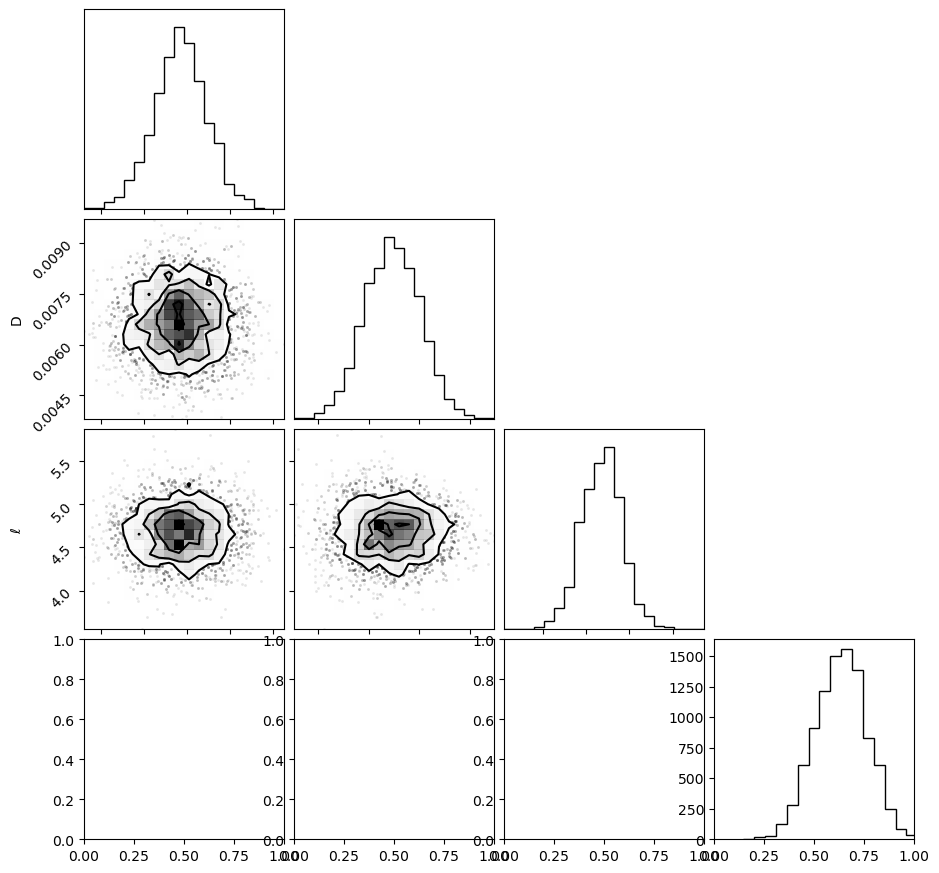

In [7]:
N_bar = 100
mask_angles = [0,10,20,30,40,50,60,70,80]
true_D = 0.007

# define 9 colours for the 9 masks
colors = ['darkviolet', 'royalblue', 'dodgerblue', 'teal', 'green', 
          'limegreen', 'orange', 'crimson', 'maroon']
alphas = [0.3, 0.5, 0.7, 0.9]
for mask_angle in mask_angles:
    # select c as  the colour based on the index of the mask_angle
    c = colors[mask_angles.index(mask_angle)]

    # Read in the samples
    samples = np.loadtxt(f'../log_dir/Masking/Dipole/nbar_{N_bar}_mask_{mask_angle}/chains/equal_weighted_post.txt', skiprows=1)
    
    # Corner plot
    corner.corner(samples, 
                        labels=[r'$\bar N$', 'D', r'$\ell$', r'$b$'],
                        truths=[N_bar, true_D, 2*np.pi - np.radians(96), np.radians(48)],
                        truth_color='r')
    # plt.savefig(f'../log_dir/Masking/Dipole/cornerplot_Nbar_{N_bar}_mask_{mask_angle}_D_0.007.png', dpi=300)
    plt.show()
    
    # Dipole amplitude posterior
    D_data = samples[:,1]
    
    plt.figure(figsize=(4,4))
    corner.corner(D_data, labels=["$D$"], show_titles=False,
                            title_fmt=".4f", quantiles=[0.5, 0.5, 0.5],
                            title_kwargs={"fontsize": 10},
                    color="k",  # color for median line and edges
                    hist_kwargs={"alpha": 0.9, "color": c, "edgecolor": "k", "linewidth": 1.5, "histtype": "stepfilled"},
                    smooth1d_kwargs={"color": c, "alpha": 0.6})

    plt.axvline(true_D, color='red', linestyle='--', label='True D', linewidth=1.5)
    plt.xlim(0,0.025)
    plt.tight_layout()
    # plt.savefig(f'../log_dir/Masking/Dipole/Nbar_{N_bar}_mask_{mask_angle}_D_0.007_posterior.png', dpi=300)
    
    # 2D direction contours 
    l, b = samples[:, 2], samples[:, 3]
    # Create maps for each vector
    smooth_sigma = 0.1
    smooth_map = process_vector_component(l, b, NSIDE, smooth_sigma)
    X, Y, P_xy, t_contours = get_projection_and_contours(smooth_map)

    #plot
    # hp.projview(smooth_map, cmap="Blues", graticule=True, graticule_labels=True)
    empty_map = np.full(hp.nside2npix(64), np.nan)


    hp.projview(
        empty_map,
        cmap="Blues",         # won't matter since map is NaN
        graticule=True,
        graticule_labels=True,
        min=0, max=1,
        cbar=False)         # required to suppress warnings even if data is NaN
    

    newprojplot(theta=dipole_theta, phi=dipole_phi, marker="*", color="k", markersize=20, zorder=5)

    # Fill the central most contour
    plt.contourf(X, Y, P_xy, levels=[t_contours[-1], P_xy.max()], colors=[c],alpha=alphas[-1])
    
    # Fill the other contours
    for i in range(len(t_contours) - 1):
        plt.contourf(X, Y, P_xy, levels=[t_contours[i], t_contours[i+1]], colors=[c], alpha=alphas[i])
    
    # Plot the contour lines to show boundaries
    plt.contour(X, Y, P_xy, levels=t_contours, colors=c, linewidths=1.5)
    plt.tight_layout()
    
    # plt.savefig(f'../log_dir/Masking/Dipole/nbar_{N_bar}_mask_{mask_angle}_contours.png', dpi=300)
break

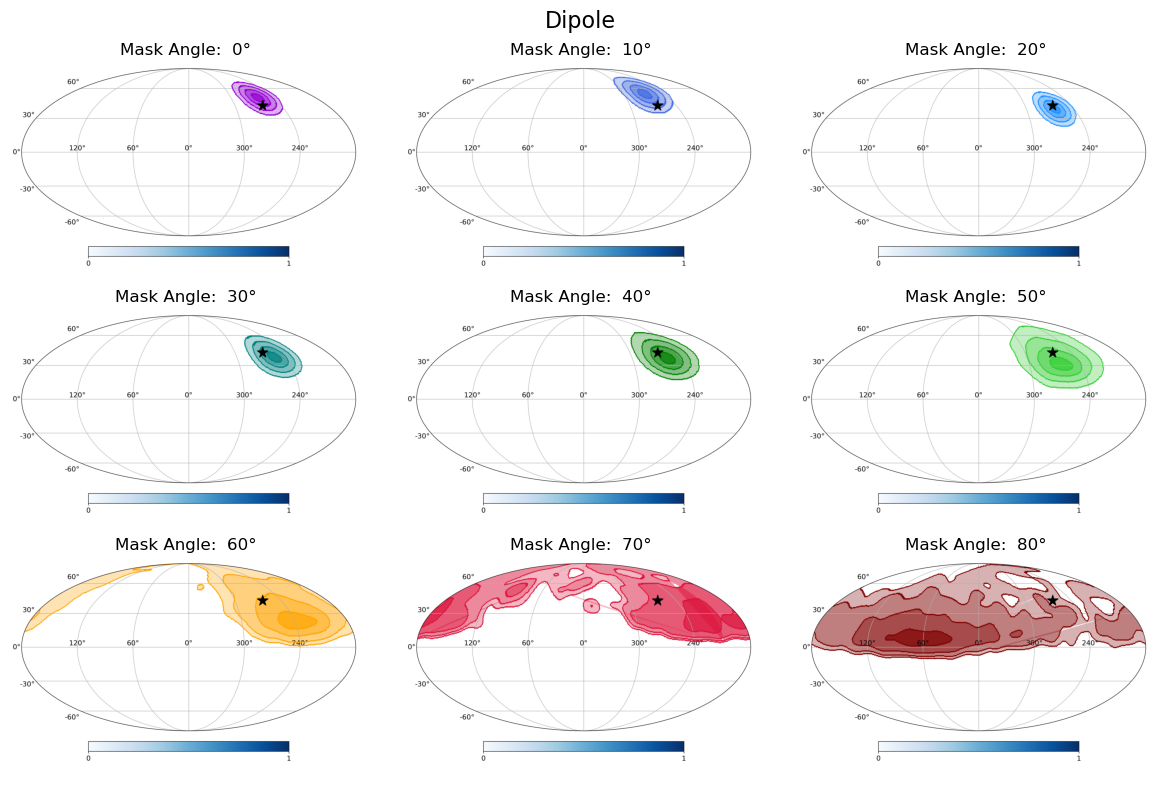

In [8]:
import os
import matplotlib.image as mpimg
folder_path = '../log_dir/Masking/Dipole/'

N_bar = 100
mask_angles = [0,10,20,30,40,50,60,70,80]

# for mask_angle in mask_angles:
image_files = [f'nbar_{N_bar}_mask_{mask_angle}_contours.png' for mask_angle in mask_angles]

missing_files = [f for f in image_files if not os.path.exists(os.path.join(folder_path, f))]
if missing_files:
    print(f'Warning: Missing images for mask angle = {mask_angle}: {missing_files}')


fig, axes = plt.subplots(3, 3, figsize=(12, 8))
fig.suptitle(f'Dipole', fontsize=16) 

for ax, img_file, mask_angle in zip(axes.flat, image_files, mask_angles):
    img = mpimg.imread(os.path.join(folder_path, img_file))
    ax.imshow(img)
    ax.axis('off') 
    ax.set_title(r'Mask Angle: ' + f' {mask_angle}°', fontsize=12)

plt.tight_layout()
# plt.savefig(folder_path+f'/combined_masked_distributions.png', dpi=300)
plt.show()
plt.close()

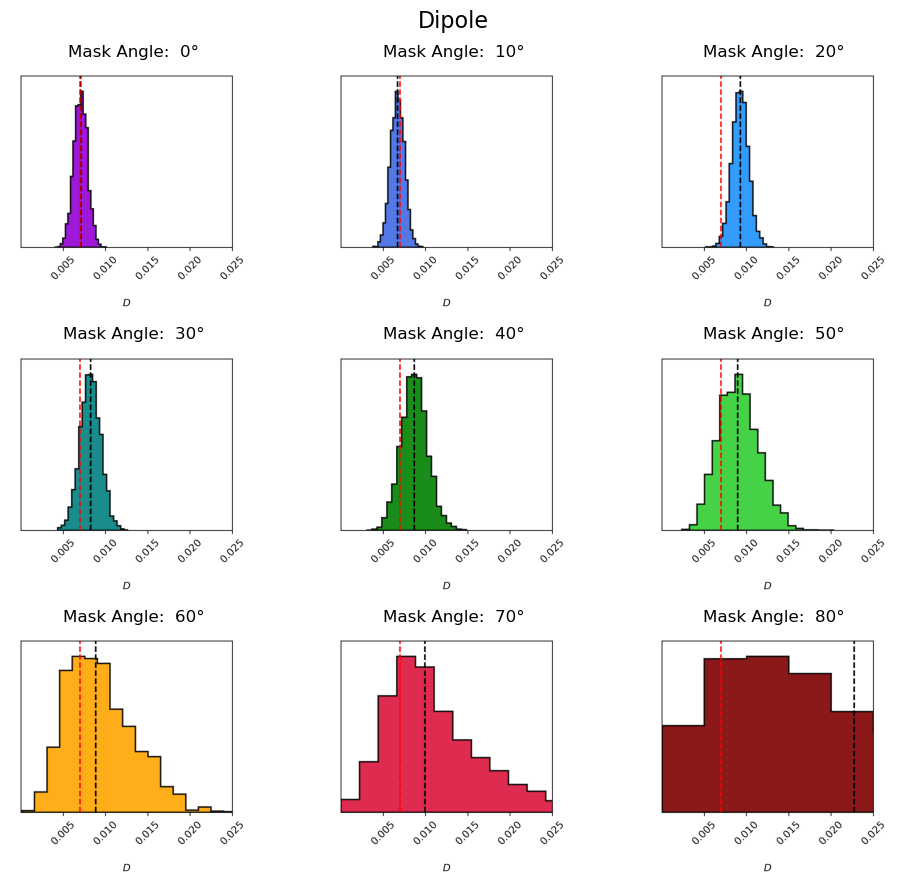

In [37]:
import os
import matplotlib.image as mpimg
folder_path = '../log_dir/Masking/Dipole/'

N_bar = 100
mask_angles = [0,10,20,30,40,50,60,70,80]

# for mask_angle in mask_angles:
image_files = [f'Nbar_{N_bar}_mask_{mask_angle}_D_0.007_posterior.png' for mask_angle in mask_angles]

missing_files = [f for f in image_files if not os.path.exists(os.path.join(folder_path, f))]
if missing_files:
    print(f'Warning: Missing images for mask angle = {mask_angle}: {missing_files}')


fig, axes = plt.subplots(3, 3, figsize=(10, 9))
fig.suptitle(f'Dipole', fontsize=16) 

for ax, img_file, mask_angle in zip(axes.flat, image_files, mask_angles):
    img = mpimg.imread(os.path.join(folder_path, img_file))
    ax.imshow(img)
    ax.axis('off') 
    ax.set_title(r'Mask Angle: ' + f' {mask_angle}°', fontsize=12)

plt.tight_layout()
# plt.savefig(folder_path+f'/combined_masked_distributions.png', dpi=300)
plt.show()
plt.close()

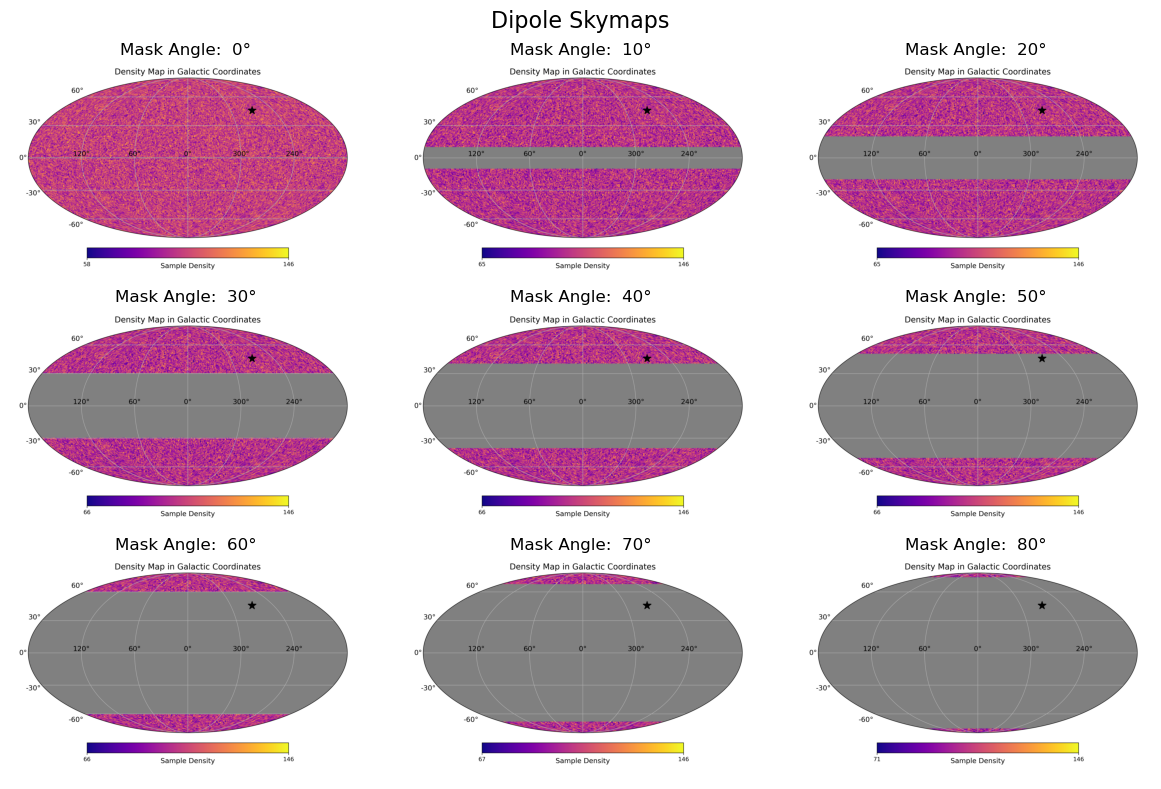

In [9]:
N_bar = 100
D=0.007
mask_angles = [0,10,20,30,40,50,60,70,80]

folder_path = '../log_dir/Masking/Dipole/Skymaps/'

# for mask_angle in mask_angles:
image_files = [f'skymap_Nbar_{N_bar}_D_{D}_mask_{mask_angle}.png' for mask_angle in mask_angles]

missing_files = [f for f in image_files if not os.path.exists(os.path.join(folder_path, f))]
if missing_files:
    print(f'Warning: Missing images for mask angle = {mask_angle}: {missing_files}')


fig, axes = plt.subplots(3, 3, figsize=(12, 8))
fig.suptitle(f'Dipole Skymaps', fontsize=16) 

for ax, img_file, mask_angle in zip(axes.flat, image_files, mask_angles):
    img = mpimg.imread(os.path.join(folder_path, img_file))
    ax.imshow(img)
    ax.axis('off') 
    ax.set_title(r'Mask Angle: ' + f' {mask_angle}°', fontsize=12)

plt.tight_layout()
# plt.savefig(folder_path+f'/combined_masked_skymaps.png', dpi=300)
plt.show()
plt.close()

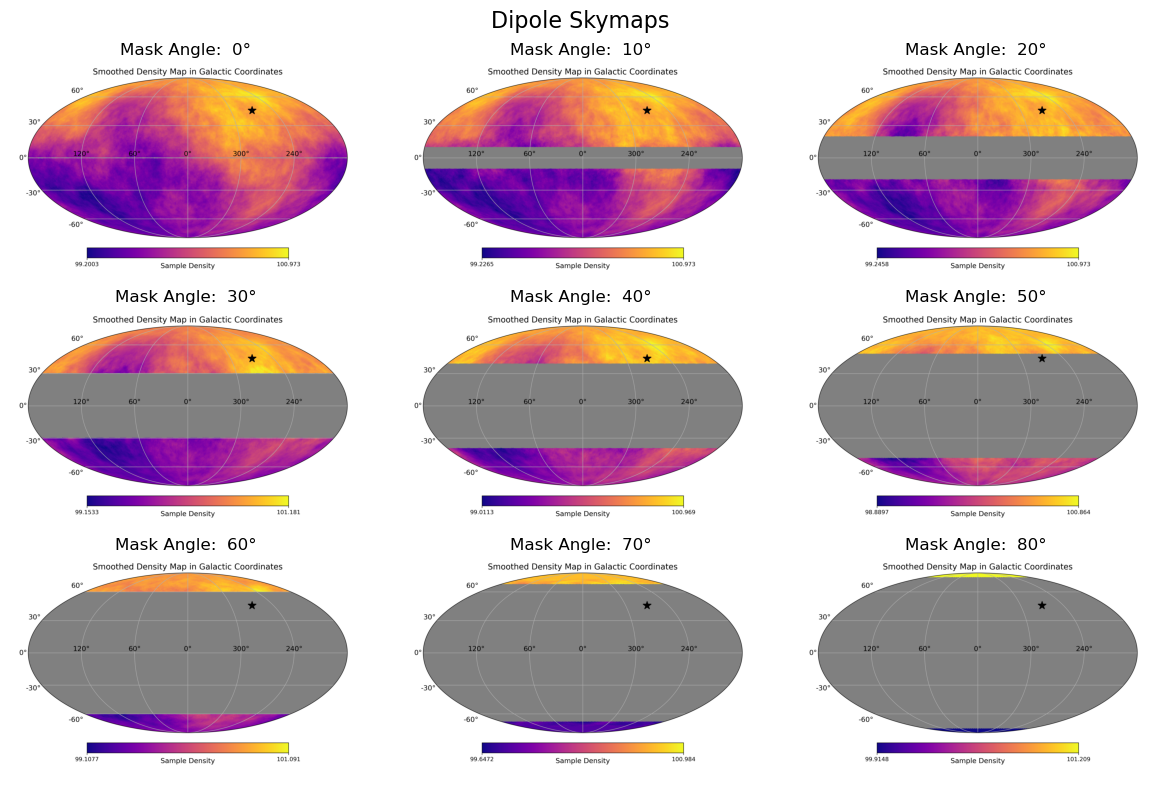

In [10]:
N_bar = 100
D=0.007
mask_angles = [0,10,20,30,40,50,60,70,80]

folder_path = '../log_dir/Masking/Dipole/Skymaps/'

# for mask_angle in mask_angles:
image_files = [f'smoothed_skymap_Nbar_{N_bar}_D_{D}_mask_{mask_angle}.png' for mask_angle in mask_angles]

missing_files = [f for f in image_files if not os.path.exists(os.path.join(folder_path, f))]
if missing_files:
    print(f'Warning: Missing images for mask angle = {mask_angle}: {missing_files}')


fig, axes = plt.subplots(3, 3, figsize=(12, 8))
fig.suptitle(f'Dipole Skymaps', fontsize=16) 

for ax, img_file, mask_angle in zip(axes.flat, image_files, mask_angles):
    img = mpimg.imread(os.path.join(folder_path, img_file))
    ax.imshow(img)
    ax.axis('off') 
    ax.set_title(r'Mask Angle: ' + f' {mask_angle}°', fontsize=12)

plt.tight_layout()
# plt.savefig(folder_path+f'/combined_masked_smoothed_skymaps.png', dpi=300)
plt.show()
plt.close()

In [40]:
# bayes factors
N_bar = 100
mask_angle = 20
filepath = f'../log_dir/Masking/Dipole/nbar_{N_bar}_mask_{mask_angle}/info/results.json'
with open(filepath, 'r') as f:
    data = json.load(f)

evidence = data['logz']


-120842.2861828004

In [166]:
N_bar = 100
mask_angles = [0,10,20,30,40,50,60,70,80]
N_bars = [1, 5, 10, 20, 40, 60, 80, 100]
true_D = 0.007
pathname = '../log_dir/Dipole_Data/Masking/'

# define 9 colours for the 9 masks
colors = ['darkviolet', 'royalblue', 'dodgerblue', 'teal', 'green', 
          'limegreen', 'orange', 'crimson', 'maroon']
alphas = [0.3, 0.5, 0.7, 0.9]

for N_bar in N_bars:
    # Read in the samples
    data = np.load(pathname+f'Datasets/Raw_Files/skymap_data_Nbar_{N_bar}_0.npy',
                    allow_pickle=True).item()
    m = data['m']
    metadata = data['metadata']
    NSIDE = metadata['NSIDE']
    dipole_theta = metadata['dipole_theta']
    dipole_phi = metadata['dipole_phi']

    for mask_angle in mask_angles:
        m_plot, m_fit, fit_mask = mask_data(NSIDE, m, mask_angle)

    ### Skymaps
        dipole_plotting(m_plot, dipole_theta, dipole_phi,
                        title='Density Map in Galactic Coordinates', unit="Sample Density",
                        cmap=cmap)
        plt.savefig(pathname+f'Figures/Skymaps/Unsmoothed/skymap_Nbar_{N_bar}_D_{true_D}_mask_{mask_angle}.png', dpi=300)
        plt.close()

        smooth_map = compute_smooth_map(m, angle_scale=1)
        smooth_map, m_fit, fit_mask = mask_data(NSIDE, smooth_map, mask_angle)

        dipole_plotting(smooth_map, dipole_theta, dipole_phi,
                        title='Smooth Density Map in Galactic Coordinates', unit="Sample Density",
                        cmap=cmap)
        plt.savefig(pathname+f'Figures/Skymaps/Smoothed/smoothed_skymap_Nbar_{N_bar}_D_{true_D}_mask_{mask_angle}.png', dpi=300)
        plt.close()


    ### CornerPlot
        # # select c as  the colour based on the index of the mask_angle
        c = colors[mask_angles.index(mask_angle)]

        # # Read in the samples
        samples = np.loadtxt(pathname + f'/Dipole_model/Nbar_{N_bar}/Nbar_{N_bar}_mask_{mask_angle}/chains/equal_weighted_post.txt', skiprows=1)

    
        # # Corner plot
        corner.corner(samples, 
                            labels=[r'$\bar N$', 'D', r'$\ell$', r'$b$'],
                            truths=[N_bar, true_D, 2*np.pi - np.radians(96), np.radians(48)],
                            truth_color='r')
        plt.savefig(pathname+f'Figures/Cornerplots/Dipole/cornerplot_Nbar_{N_bar}_D_{true_D}_mask_{mask_angle}.png', dpi=300)
        # plt.show()
        plt.close()
        
    ### Dipole amplitude posterior
        D_data = samples[:,1]
        
        plt.figure(figsize=(4,4))
        corner.corner(D_data, labels=["$D$"], show_titles=False,
                                title_fmt=".4f", quantiles=[0.5, 0.5, 0.5],
                                title_kwargs={"fontsize": 10},
                        color="k",  # color for median line and edges
                        hist_kwargs={"alpha": 0.9, "color": c, "edgecolor": "k", "linewidth": 1.5, "histtype": "stepfilled"},
                        smooth1d_kwargs={"color": c, "alpha": 0.6})

        plt.axvline(true_D, color='red', linestyle='--', label='True D', linewidth=1.5)
        plt.tight_layout()

        plt.savefig(pathname+f'Figures/Amplitude_Posterior/D_distribution_Nbar_{N_bar}_D_{true_D}_mask_{mask_angle}.png', dpi=300)
        plt.close()
        
        # # 2D direction contours 
        l, b = samples[:, 2], samples[:, 3]
        # Create maps for each vector
        smooth_sigma = 0.1
        smooth_map = process_vector_component(l, b, NSIDE, smooth_sigma)
        X, Y, P_xy, t_contours = get_projection_and_contours(smooth_map)

        # #plot
        # hp.projview(smooth_map, cmap="Blues", graticule=True, graticule_labels=True)
        empty_map = np.full(hp.nside2npix(64), np.nan)


        hp.projview(
            empty_map,
            cmap="Blues",         # won't matter since map is NaN
            graticule=True,
            graticule_labels=True,
            min=0, max=1,
            cbar=False)         # required to suppress warnings even if data is NaN
        
        newprojplot(theta=dipole_theta, phi=dipole_phi, marker="*", color="k", markersize=20, zorder=5)

        # Fill the central most contour
        plt.contourf(X, Y, P_xy, levels=[t_contours[-1], P_xy.max()], colors=[c],alpha=alphas[-1])
        
        # Fill the other contours
        for i in range(len(t_contours) - 1):
            plt.contourf(X, Y, P_xy, levels=[t_contours[i], t_contours[i+1]], colors=[c], alpha=alphas[i])

        # Plot the contour lines to show boundaries
        plt.contour(X, Y, P_xy, levels=t_contours, colors=c, linewidths=1.5)
        plt.tight_layout()
        # plt.show()
        plt.savefig(pathname+f'Figures/Contour_Distributions/contour_Nbar_{N_bar}_D_{true_D}_mask_{mask_angle}.png', dpi=300)
        plt.close()
        break
    break

<Figure size 400x400 with 0 Axes>

In [8]:
# Bayes factors

mask_angles = [0,10,20,30,40,50,60,70,80]
N_bars = [1, 5, 10, 20, 40, 60, 80, 100]
true_D = 0.007
pathname = '../log_dir/Dipole_Data/Masking/'
models = ['Monopole_model', 'Dipole_model']
# set up dataframe to store results
df = pd.DataFrame(columns=['model', 'N_bar', 'mask_angle', 'evidence'])

for model in models:
    for N_bar in N_bars:
        for mask_angle in mask_angles:
            filepath = pathname + f'{model}/Nbar_{N_bar}/Nbar_{N_bar}_mask_{mask_angle}/info/results.json'
            if os.path.exists(filepath):
                with open(filepath, 'r') as f:
                    data = json.load(f)
                evidence = data['logz']
                # append to a dataframe, need columns for model, N_bar, mask_angle, evidence
                new_row = pd.DataFrame([{'model': model, 'N_bar': N_bar, 'mask_angle': mask_angle, 'evidence': evidence}])
                df = pd.concat([df, new_row], ignore_index=True)
            else:
                print(f'File not found: {filepath}')

df

File not found: ../log_dir/Dipole_Data/Masking/Dipole_model/Nbar_100/Nbar_100_mask_0/info/results.json
File not found: ../log_dir/Dipole_Data/Masking/Dipole_model/Nbar_100/Nbar_100_mask_10/info/results.json
File not found: ../log_dir/Dipole_Data/Masking/Dipole_model/Nbar_100/Nbar_100_mask_20/info/results.json
File not found: ../log_dir/Dipole_Data/Masking/Dipole_model/Nbar_100/Nbar_100_mask_30/info/results.json
File not found: ../log_dir/Dipole_Data/Masking/Dipole_model/Nbar_100/Nbar_100_mask_40/info/results.json
File not found: ../log_dir/Dipole_Data/Masking/Dipole_model/Nbar_100/Nbar_100_mask_50/info/results.json
File not found: ../log_dir/Dipole_Data/Masking/Dipole_model/Nbar_100/Nbar_100_mask_60/info/results.json
File not found: ../log_dir/Dipole_Data/Masking/Dipole_model/Nbar_100/Nbar_100_mask_70/info/results.json
File not found: ../log_dir/Dipole_Data/Masking/Dipole_model/Nbar_100/Nbar_100_mask_80/info/results.json


model N_bar mask_angle      evidence
0    Monopole_model     1          0 -64024.717120
1    Monopole_model     1         10 -52989.196257
2    Monopole_model     1         20 -42340.496299
3    Monopole_model     1         30 -32408.397191
4    Monopole_model     1         40 -22908.626070
..              ...   ...        ...           ...
130    Dipole_model    80         40 -63862.834512
131    Dipole_model    80         50 -41402.908350
132    Dipole_model    80         60 -23765.989969
133    Dipole_model    80         70 -10989.778028
134    Dipole_model    80         80  -2648.612251

[135 rows x 4 columns]

In [9]:
df_dipole = df[df['model'] == 'Dipole_model']
df_monopole = df[df['model'] == 'Monopole_model']

rows = []

for (N_bar, mask_angle), group in df_dipole.groupby(['N_bar', 'mask_angle']):
    dipole_evidence = group['evidence'].values[0]
    monopole_evidence = df_monopole[
        (df_monopole['N_bar'] == N_bar) & (df_monopole['mask_angle'] == mask_angle)
    ]['evidence'].values[0]
    
    bayes_factor = dipole_evidence - monopole_evidence
    rows.append({'N_bar': N_bar, 'mask_angle': mask_angle, 'bayes_factor': bayes_factor})

df_bayes_factors = pd.DataFrame(rows)
df_bayes_factors

N_bar  mask_angle  bayes_factor
0       1           0     -1.495857
1       1          10     -1.769000
2       1          20     -2.226568
3       1          30     -1.873138
4       1          40     -2.178653
..    ...         ...           ...
58     80          40      4.619955
59     80          50      1.853382
60     80          60     -1.512811
61     80          70     -1.090977
62     80          80     -1.803227

[63 rows x 3 columns]

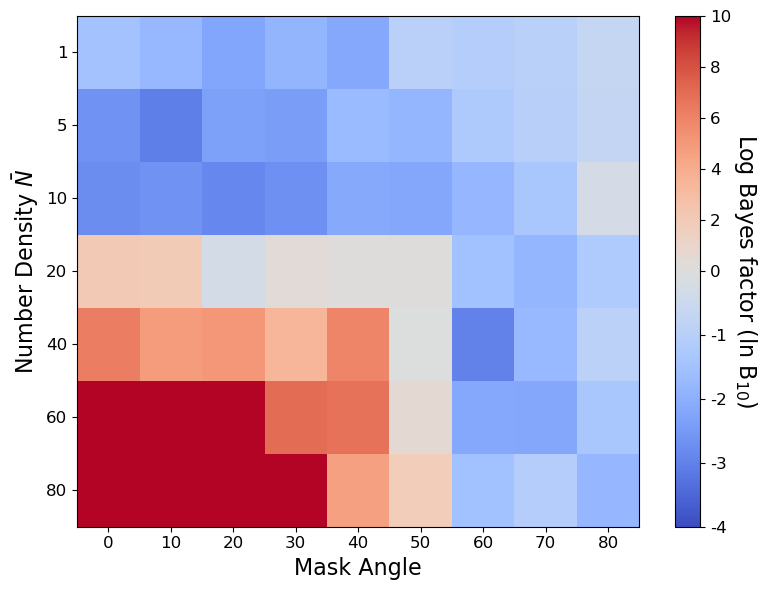

In [10]:
# Sort and map mask_angle and N_bar to consistent indices
mask_angles = sorted(df_bayes_factors['mask_angle'].unique())
N_bars = sorted(df_bayes_factors['N_bar'].unique())

# Create index mappings
mask_angle_to_idx = {val: idx for idx, val in enumerate(mask_angles)}
Nbar_to_idx = {val: idx + 1 for idx, val in enumerate(N_bars)}  # Start from 1 to match original structure

# Prepare values for plotting
x_vals = df_bayes_factors['mask_angle'].map(mask_angle_to_idx).values
y_vals = df_bayes_factors['N_bar'].map(Nbar_to_idx).values
weights = df_bayes_factors['bayes_factor'].values

x_vals = np.array(x_vals)
y_vals = np.array(y_vals)
weights = np.array(weights)

# Define color normalization
vmin = -4
vmax = 10
norm = mcolors.TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)

# Define bin edges
x_min, x_max = min(x_vals), max(x_vals)
y_min, y_max = min(y_vals), max(y_vals)

plt.figure(figsize=(8, 6))
plt.hist2d(
    x_vals, y_vals,
    bins=[np.arange(x_min, x_max + 2, 1), np.arange(y_min, y_max + 2, 1)],
    weights=weights, cmap='coolwarm', norm=norm)

# Colorbar
cbar = plt.colorbar()
cbar.set_label(r'Log Bayes factor (ln B$_{10})$', rotation=270, labelpad=20, fontsize=16)
ticks = [-4, -3, -2,-1, 0, 2, 4, 6, 8, 10]
cbar.set_ticks(ticks)
cbar.set_ticklabels([str(t) for t in ticks], fontsize=12)

# Axis labels and ticks
plt.xlabel('Mask Angle', fontsize=16)
plt.ylabel(r'Number Density $\bar{N}$', fontsize=16)
plt.xticks(np.arange(x_min + 0.5, x_max + 1, 1), mask_angles, fontsize=12)
plt.yticks(np.arange(y_min + 0.5, y_max + 1, 1), N_bars, fontsize=12)
plt.gca().invert_yaxis()
plt.tight_layout()
# plt.savefig('../log_dir/Dipole_Data/Masking/Figures/bayes_factor_comparison_matrix.png', dpi=300)
plt.show()

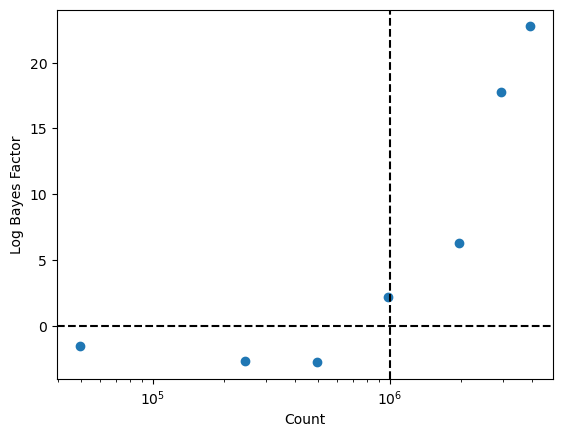

In [12]:
df_bayes_factors_zero_mask = df_bayes_factors[df_bayes_factors['mask_angle'] == 0]
count = df_bayes_factors_zero_mask['N_bar']* (12 * 64**2)
plt.scatter(count, df_bayes_factors_zero_mask['bayes_factor'])
plt.xscale('log')
plt.xlabel('Count')
plt.ylabel('Log Bayes Factor')
plt.axhline(0, color='k', linestyle='--', label='No Preference', linewidth=1.5)
plt.axvline(1e6, color='k', linestyle='--', label='Monopole Preferred', linewidth=1.5)
plt.show()

In [211]:
# Combined Figures
import matplotlib.image as mpimg
import matplotlib.gridspec as gridspec

skymap_path     = '../log_dir/Dipole_Data/Masking/Figures/Skymaps/Smoothed/smoothed_skymap_Nbar_{}_D_0.007_mask_{}.png'
contour_path    = '../log_dir/Dipole_Data/Masking/Figures/Contour_Distributions/D_distribution_Nbar_{}_D_0.007_mask_{}.png'
amplitude_path  = '../log_dir/Dipole_Data/Masking/Figures/Amplitude_Posterior/D_distribution_Nbar_{}_D_0.007_mask_{}.png'
corner_path    = '../log_dir/Dipole_Data/Masking/Figures/Cornerplots/Dipole/cornerplot_Nbar_{}_D_0.007_mask_{}.png'

output_dir = '../log_dir/Dipole_Data/Masking/Figures/Combined_Figures/'
os.makedirs(output_dir, exist_ok=True)

N_bars = [1, 5, 10, 20, 40, 60, 80, 100]
mask_angles = [0, 10, 20, 30, 40, 50, 60, 70, 80]


# Loop through N_bars and mask_angles
for N_bar in N_bars:
    for mask_angle in mask_angles:
        try:
            # Load the images
            images = [
                mpimg.imread(skymap_path.format(N_bar, mask_angle)),
                mpimg.imread(contour_path.format(N_bar, mask_angle)),
                mpimg.imread(amplitude_path.format(N_bar, mask_angle)),
                mpimg.imread(corner_path.format(N_bar, mask_angle))
            ]

        # Create subplot with different column widths
            fig = plt.figure(figsize=(12, 10))
            gs = gridspec.GridSpec(2, 2, width_ratios=[3, 2])

            axs = [
                fig.add_subplot(gs[0, 0]),
                fig.add_subplot(gs[1, 0]),
                fig.add_subplot(gs[0, 1]),
                fig.add_subplot(gs[1, 1])
            ]

            for ax, img in zip(axs, images):
                ax.imshow(img)
                ax.axis('off')

            plt.tight_layout()
            output_path = os.path.join(output_dir, f'combined_figure_{N_bar}_{mask_angle}.png')
            plt.savefig(output_path, dpi=300)
            # plt.show()
            plt.close(fig)
            # break
        except FileNotFoundError as e:
            print(f"Skipping N_bar {N_bar}, mask_angle {mask_angle} due to missing file: {e}")

In [222]:
### COMBINED CONTOURS

D=0.007
mask_angles = [0,10,20,30,40,50,60,70,80]

folder_path = '../log_dir/Dipole_Data/Masking/Figures/Contour_Distributions/'

for N_bar in N_bars:

    # for mask_angle in mask_angles:
    image_files = [f'D_distribution_Nbar_{N_bar}_D_{D}_mask_{mask_angle}.png' for mask_angle in mask_angles]

    missing_files = [f for f in image_files if not os.path.exists(os.path.join(folder_path, f))]
    if missing_files:
        print(f'Warning: Missing images for mask angle = {mask_angle}: {missing_files}')


    fig, axes = plt.subplots(3, 3, figsize=(12, 8))
    fig.suptitle(f'Dipole Skymaps, Nbar = {N_bar}', fontsize=16)

    for ax, img_file, mask_angle in zip(axes.flat, image_files, mask_angles):
        img = mpimg.imread(os.path.join(folder_path, img_file))
        ax.imshow(img)
        ax.axis('off') 
        ax.set_title(r'Mask Angle: ' + f' {mask_angle}°', fontsize=12)

    plt.tight_layout()
    plt.savefig(folder_path+f'/combined_countours_masked_Nbar_{N_bar}.png', dpi=300)
    # plt.show()
    plt.close()

In [221]:
### COMBINED AMPLITUDE POSTERIOR

D=0.007
mask_angles = [0,10,20,30,40,50,60,70,80]

folder_path = '../log_dir/Dipole_Data/Masking/Figures/Amplitude_Posterior/'

for N_bar in N_bars:

    # for mask_angle in mask_angles:
    image_files = [f'D_distribution_Nbar_{N_bar}_D_{D}_mask_{mask_angle}.png' for mask_angle in mask_angles]

    missing_files = [f for f in image_files if not os.path.exists(os.path.join(folder_path, f))]
    if missing_files:
        print(f'Warning: Missing images for mask angle = {mask_angle}: {missing_files}')


    fig, axes = plt.subplots(3, 3, figsize=(10, 9))
    fig.suptitle(f'Dipole Skymaps, Nbar = {N_bar}', fontsize=16)

    for ax, img_file, mask_angle in zip(axes.flat, image_files, mask_angles):
        img = mpimg.imread(os.path.join(folder_path, img_file))
        ax.imshow(img)
        ax.axis('off') 
        ax.set_title(r'Mask Angle: ' + f' {mask_angle}°', fontsize=12)

    plt.tight_layout()
    plt.savefig(folder_path+f'/combined_amplitude_posteriors_Nbar_{N_bar}.png', dpi=300)
    # plt.show()
    plt.close()

# Averaging the posteriors over the 20 iterations

In [13]:
# Bayes factors
mask_angles = [0,10,20,30,40,50,60,70,80]
N_bars = [1, 5, 10, 20, 40, 60, 80, 100]
true_D = 0.007
pathname = '../log_dir/Dipole_Data/Masking/'
models = ['Monopole_model', 'Dipole_model']
# set up dataframe to store results
df = pd.DataFrame(columns=['model', 'N_bar', 'mask_angle', 'evidence'])

for model in models:
    for N_bar in N_bars:
        for mask_angle in mask_angles:
            for i in range(20):
                filepath = pathname + f'{model}/Nbar_{N_bar}/Nbar_{N_bar}_mask_{mask_angle}_iteration_{i}/info/results.json'
                if os.path.exists(filepath):
                    with open(filepath, 'r') as f:
                        data = json.load(f)
                    evidence = data['logz']
                    # append to a dataframe, need columns for model, N_bar, mask_angle, evidence
                    new_row = pd.DataFrame([{'model': model, 'N_bar': N_bar, 'mask_angle': mask_angle, 'iteration': i, 'evidence': evidence}])
                    df = pd.concat([df, new_row], ignore_index=True)
                else:
                    print(f'File not found: {filepath}')

df

model N_bar mask_angle      evidence  iteration
0     Monopole_model     1          0 -64024.717120        0.0
1     Monopole_model     1          0 -64312.993501        1.0
2     Monopole_model     1          0 -63978.406285        2.0
3     Monopole_model     1          0 -64343.113861        3.0
4     Monopole_model     1          0 -63993.102176        4.0
...              ...   ...        ...           ...        ...
2875    Dipole_model   100         80  -2707.355178       15.0
2876    Dipole_model   100         80  -2689.284949       16.0
2877    Dipole_model   100         80  -2705.137259       17.0
2878    Dipole_model   100         80  -2709.830896       18.0
2879    Dipole_model   100         80  -2727.402130       19.0

[2880 rows x 5 columns]

In [14]:
# save the dataframe to a csv file
df.to_csv(pathname + 'dipole_masked_iterations_bayes_factors.csv', index=False)

In [16]:
# Read in the saved dataframe
df_read = pd.read_csv(pathname + 'dipole_masked_iterations_bayes_factors.csv')
df_read

model  N_bar  mask_angle      evidence  iteration
0     Monopole_model      1           0 -64024.717120        0.0
1     Monopole_model      1           0 -64312.993501        1.0
2     Monopole_model      1           0 -63978.406285        2.0
3     Monopole_model      1           0 -64343.113861        3.0
4     Monopole_model      1           0 -63993.102176        4.0
...              ...    ...         ...           ...        ...
2875    Dipole_model    100          80  -2707.355178       15.0
2876    Dipole_model    100          80  -2689.284949       16.0
2877    Dipole_model    100          80  -2705.137259       17.0
2878    Dipole_model    100          80  -2709.830896       18.0
2879    Dipole_model    100          80  -2727.402130       19.0

[2880 rows x 5 columns]

In [23]:
# Filter dipole and monopole models
dipole = df[df['model'] == 'Dipole_model']
monopole = df[df['model'] == 'Monopole_model']

# Merge on N_bar, mask_angle, and iteration
merged = pd.merge(
    dipole,
    monopole,
    on=['N_bar', 'mask_angle', 'iteration'],
    suffixes=('_dipole', '_monopole')
)

# Compute Bayes factor (difference in log-evidence)
merged['bayes_factor'] = merged['evidence_dipole'] - merged['evidence_monopole']

# Optional: keep only relevant columns
result = merged[['N_bar', 'mask_angle', 'iteration', 'bayes_factor']]
# Group by N_bar and mask_angle, then compute mean of bayes_factor
df_bayes_avg = result.groupby(['N_bar', 'mask_angle'])['bayes_factor'].mean().reset_index()
df_bayes_avg

N_bar  mask_angle  bayes_factor
0       1           0     -1.451261
1       1          10     -1.408678
2       1          20     -1.329516
3       1          30     -1.016404
4       1          40     -0.848486
..    ...         ...           ...
67    100          40     10.558674
68    100          50      6.728911
69    100          60      2.012323
70    100          70      0.360295
71    100          80     -0.663994

[72 rows x 3 columns]

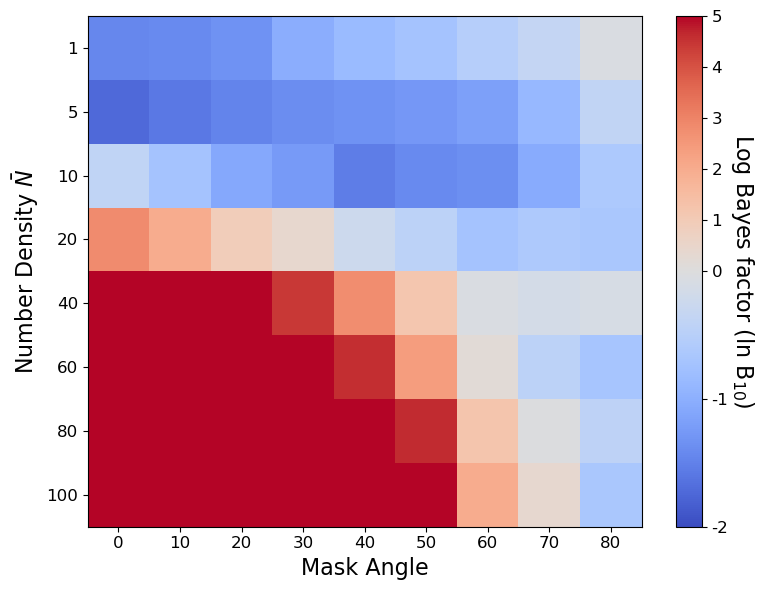

In [25]:
# Sort and map mask_angle and N_bar to consistent indices
mask_angles = sorted(df_bayes_avg['mask_angle'].unique())
N_bars = sorted(df_bayes_avg['N_bar'].unique())

# Create index mappings
mask_angle_to_idx = {val: idx for idx, val in enumerate(mask_angles)}
Nbar_to_idx = {val: idx + 1 for idx, val in enumerate(N_bars)}  # Start from 1 to match original structure

# Prepare values for plotting
x_vals = df_bayes_avg['mask_angle'].map(mask_angle_to_idx).values
y_vals = df_bayes_avg['N_bar'].map(Nbar_to_idx).values
weights = df_bayes_avg['bayes_factor'].values

x_vals = np.array(x_vals)
y_vals = np.array(y_vals)
weights = np.array(weights)

# Define color normalization
vmin = -2
vmax = 5
norm = mcolors.TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)

# Define bin edges
x_min, x_max = min(x_vals), max(x_vals)
y_min, y_max = min(y_vals), max(y_vals)

plt.figure(figsize=(8, 6))
plt.hist2d(
    x_vals, y_vals,
    bins=[np.arange(x_min, x_max + 2, 1), np.arange(y_min, y_max + 2, 1)],
    weights=weights, cmap='coolwarm', norm=norm)

# Colorbar
cbar = plt.colorbar()
cbar.set_label(r'Log Bayes factor (ln B$_{10})$', rotation=270, labelpad=20, fontsize=16)
ticks = [-2,-1, 0, 1,2,3,4,5]
cbar.set_ticks(ticks)
cbar.set_ticklabels([str(t) for t in ticks], fontsize=12)

# Axis labels and ticks
plt.xlabel('Mask Angle', fontsize=16)
plt.ylabel(r'Number Density $\bar{N}$', fontsize=16)
plt.xticks(np.arange(x_min + 0.5, x_max + 1, 1), mask_angles, fontsize=12)
plt.yticks(np.arange(y_min + 0.5, y_max + 1, 1), N_bars, fontsize=12)
plt.gca().invert_yaxis()
plt.tight_layout()
# plt.savefig('../log_dir/Dipole_Data/Masking/Figures/bayes_factor_comparison_matrix_averaged.png', dpi=300)
plt.show()

In [ ]:
# mask_angles = [0,10,20,30,40,50,60,70,80]
# N_bars = [1, 5, 10, 20, 40, 60, 80, 100]
# true_D = 0.007
# pathname = '../log_dir/Dipole_Data/Masking/'
# models = ['Monopole_model', 'Dipole_model']

# # Store per-iteration evidence
# evidence_dict = {
#     'Monopole_model': {},
#     'Dipole_model': {}
# }

# # Final dataframe of average Bayes factors
# df_bayes_avg = pd.DataFrame(columns=['N_bar', 'mask_angle', 'avg_bayes_factor', 'std_bayes_factor'])

# for N_bar in N_bars:
#     for mask_angle in mask_angles:
#         evidences = {model: [] for model in models}

#         for i in range(20):
#             for model in models:
#                 filepath = pathname + f'{model}/Nbar_{N_bar}/Nbar_{N_bar}_mask_{mask_angle}_iteration_{i}/info/results.json'
#                 if os.path.exists(filepath):
#                     with open(filepath, 'r') as f:
#                         data = json.load(f)
#                     evidences[model].append(data['logz'])
#                 else:
#                     print(f'File not found: {filepath}')

#         # Only compute Bayes factor if both models have full data
#         if len(evidences['Dipole_model']) == 20 and len(evidences['Monopole_model']) == 20:
#             diffs = np.array(evidences['Dipole_model']) - np.array(evidences['Monopole_model'])
#             avg_bf = np.mean(diffs)
#             std_bf = np.std(diffs)

#             new_row = {
#                 'N_bar': N_bar,
#                 'mask_angle': mask_angle,
#                 'avg_bayes_factor': avg_bf,
#                 'std_bayes_factor': std_bf
#             }
#             df_bayes_avg = pd.concat([df_bayes_avg, pd.DataFrame([new_row])], ignore_index=True)
#         else:
#             print(f"Skipping Nbar={N_bar}, mask_angle={mask_angle} due to missing data.")

In [351]:

N_bar = 100
mask_angles = [0,10,20,30,40,50,60,70,80]
N_bars = [1, 5, 10, 20, 40, 60, 80, 100]
true_D = 0.007
pathname = '../log_dir/Dipole_Data/Masking/'

# define 9 colours for the 9 masks
colors = ['darkviolet', 'royalblue', 'dodgerblue', 'teal', 'green', 
          'limegreen', 'orange', 'crimson', 'maroon']
alphas = [0.3, 0.5, 0.7, 0.9]

for N_bar in N_bars:
    # Read in the samples
    
    data = np.load(pathname+f'Datasets/Raw_Files/skymap_data_Nbar_{N_bar}_0.npy',
                    allow_pickle=True).item()
    m = data['m']
    metadata = data['metadata']
    NSIDE = metadata['NSIDE']
    dipole_theta = metadata['dipole_theta']
    dipole_phi = metadata['dipole_phi']

    for mask_angle in mask_angles:
        m_plot, m_fit, fit_mask = mask_data(NSIDE, m, mask_angle)

    ### Skymaps
        dipole_plotting(m_plot, dipole_theta, dipole_phi,
                        title='Density Map in Galactic Coordinates', unit="Sample Density",
                        cmap=cmap)
        # plt.savefig(pathname+f'Figures/Skymaps/Unsmoothed/skymap_Nbar_{N_bar}_D_{true_D}_mask_{mask_angle}.png', dpi=300)
        plt.close()

        smooth_map = compute_smooth_map(m, angle_scale=1)
        smooth_map, m_fit, fit_mask = mask_data(NSIDE, smooth_map, mask_angle)

        dipole_plotting(smooth_map, dipole_theta, dipole_phi,
                        title='Smooth Density Map in Galactic Coordinates', unit="Sample Density",
                        cmap=cmap)
        # plt.savefig(pathname+f'Figures/Skymaps/Smoothed/smoothed_skymap_Nbar_{N_bar}_D_{true_D}_mask_{mask_angle}.png', dpi=300)
        plt.close()


    ### CornerPlot
        # # select c as  the colour based on the index of the mask_angle
        c = colors[mask_angles.index(mask_angle)]

        # # Read in the samples
        # Take the average of the samples over the 20 iterations
        samples = np.zeros((0, 4))  # Assuming 4 parameters: N_bar, D, l, b
        for i in range(20):
            sample_i = np.loadtxt(pathname + f'/Dipole_model/Nbar_{N_bar}/Nbar_{N_bar}_mask_{mask_angle}_iteration_{i}/chains/equal_weighted_post.txt', skiprows=1)
            samples = np.vstack((samples, sample_i))
            
    # # Corner plot
        corner.corner(samples,
                            labels=[r'$\bar N$', 'D', r'$\ell$', r'$b$'],
                            truths=[N_bar, true_D, 2*np.pi - np.radians(96), np.radians(48)],
                            truth_color='r')
        # plt.savefig(pathname+f'Figures/Cornerplots/Dipole/cornerplot_Nbar_{N_bar}_D_{true_D}_mask_{mask_angle}_averaged.png', dpi=300)
        # plt.show()
        plt.close()
        
    ### Dipole amplitude posterior
        D_data = samples[:,1]
        
        plt.figure(figsize=(4,4))
        corner.corner(D_data, labels=["$D$"], show_titles=False,
                                title_fmt=".4f", quantiles=[0.5, 0.5, 0.5],
                                title_kwargs={"fontsize": 10},
                        color="k",  # color for median line and edges
                        hist_kwargs={"alpha": 0.9, "color": c, "edgecolor": "k", "linewidth": 1.5, "histtype": "stepfilled"},
                        smooth1d_kwargs={"color": c, "alpha": 0.6})

        plt.axvline(true_D, color='red', linestyle='--', label='True D', linewidth=1.5)
        plt.tight_layout()

        # plt.savefig(pathname+f'Figures/Amplitude_Posterior/D_distribution_Nbar_{N_bar}_D_{true_D}_mask_{mask_angle}_averaged.png', dpi=300)
        plt.close()
        
        # # 2D direction contours 
        l, b = samples[:, 2], samples[:, 3]
        # Create maps for each vector
        smooth_sigma = 0.1
        smooth_map = process_vector_component(l, b, NSIDE, smooth_sigma)
        X, Y, P_xy, t_contours = get_projection_and_contours(smooth_map)

        # #plot
        # hp.projview(smooth_map, cmap="Blues", graticule=True, graticule_labels=True)
        empty_map = np.full(hp.nside2npix(64), np.nan)


        hp.projview(
            empty_map,
            cmap="Blues",         # won't matter since map is NaN
            graticule=True,
            graticule_labels=True,
            min=0, max=1,
            cbar=False)         # required to suppress warnings even if data is NaN
        
        newprojplot(theta=dipole_theta, phi=dipole_phi, marker="*", color="k", markersize=20, zorder=5)

        # Fill the central most contour
        plt.contourf(X, Y, P_xy, levels=[t_contours[-1], P_xy.max()], colors=[c],alpha=alphas[-1])
        
        # Fill the other contours
        for i in range(len(t_contours) - 1):
            plt.contourf(X, Y, P_xy, levels=[t_contours[i], t_contours[i+1]], colors=[c], alpha=alphas[i])

        # Plot the contour lines to show boundaries
        plt.contour(X, Y, P_xy, levels=t_contours, colors=c, linewidths=1.5)
        plt.tight_layout()
        # plt.show()
        # plt.savefig(pathname+f'Figures/Contour_Distributions/contour_Nbar_{N_bar}_D_{true_D}_mask_{mask_angle}_averaged.png', dpi=300)
        plt.close()
        
        break
    break

<Figure size 400x400 with 0 Axes>

KeyboardInterrupt: 

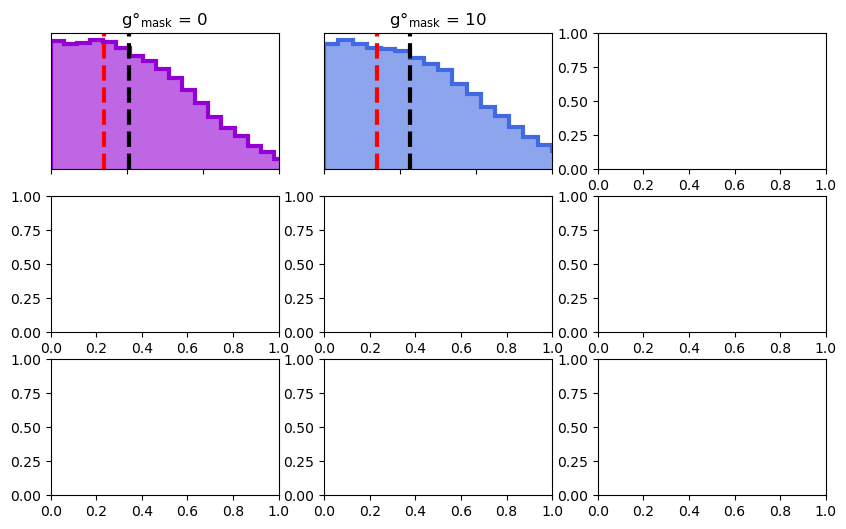

In [ ]:

mask_angles = [0, 10, 20, 30, 40, 50, 60, 70, 80]
N_bars = [1, 5, 10, 20, 40, 60, 80, 100]
true_D = 0.007
pathname = '../log_dir/Dipole_Data/Masking/'

# Define 9 colours for the 9 masks
colors = ['darkviolet', 'royalblue', 'dodgerblue', 'teal', 'green',
          'limegreen', 'orange', 'crimson', 'maroon']

for N_bar in N_bars:
    # Read metadata
    data = np.load(pathname + f'Datasets/Raw_Files/skymap_data_Nbar_{N_bar}_0.npy',
                   allow_pickle=True).item()
    metadata = data['metadata']

    fig, axs = plt.subplots(3, 3, figsize=(10, 6), sharex=False, sharey=False)
    axs = axs.flatten()

    for i, mask_angle in enumerate(mask_angles):
        c = colors[i]
        samples = np.zeros((0, 4))  # Assuming columns: N_bar, D, l, b

        for j in range(20):
            sample_path = pathname + f'/Dipole_model/Nbar_{N_bar}/Nbar_{N_bar}_mask_{mask_angle}_iteration_{j}/chains/equal_weighted_post.txt'
            if os.path.exists(sample_path):
                sample_i = np.loadtxt(sample_path, skiprows=1)
                samples = np.vstack((samples, sample_i))

        D_data = samples[:, 1]

        ax = axs[i]
        # 1. Plot filled histogram with lighter edge color and thickness
        axs[i].hist(D_data, bins=30, density=True,
                    color=c,
                    edgecolor=c,
                    linewidth=0.8,
                    histtype='stepfilled',
                    alpha=0.6)

        # 2. Overlay histogram outline with no fill, thick dark edge
        axs[i].hist(D_data, bins=30, density=True,
                    histtype='step',
                    color=c,
                    linewidth=3.0)


        median_D = np.median(D_data)
        ax.axvline(median_D, color='k', linestyle='--', linewidth=3)
        ax.axvline(true_D, color='r', linestyle='--', linewidth=3)

        
        axs[i].set_title(f"g\u00b0$_{{\\mathrm{{mask}}}}$ = {mask_angle}", fontsize=12)
        # Remove all y-axis ticks and labels
        ax.set_yticks([])
        ax.set_ylabel('')
        axs[i].set_xlim(0, 0.03)

        # For bottom row, set x-ticks exactly as requested
        if i >= 6:  # bottom row
            axs[i].set_xticks([0.0, 0.01, 0.02, 0.03])
            axs[i].tick_params(axis='x', labelsize=9)
        else:
            # For top two rows, keep ticks but hide labels
            axs[i].tick_params(axis='x', labelbottom=False)

    # Remove any unused subplot axes
    for j in range(len(mask_angles), len(axs)):
        fig.delaxes(axs[j])

    # Shared x and y labels
    fig.text(0.51, 0.03, r'Dipole Amplitude $\mathcal{D}$', ha='center', fontsize=16)
    fig.text(0.09, 0.5, 'Probability Density', va='center', rotation='vertical', fontsize=16)
    plt.suptitle(f'Dipole Amplitude Posterior: $\\bar{{N}}$ = {N_bar}', fontsize=20, y=0.99)
    # plt.tight_layout(rect=[0.06, 0.06, 1, 0.96])

    # plt.savefig(pathname + f'Figures/Amplitude_Posterior/combined_D_distributions_Nbar_{N_bar}_averaged.png', dpi=300)
    # plt.show()
    plt.close()
    break

In [350]:
plt.close()

# Now the dipole + quadrupole data 

# Update: I had an error in the code, it was fitting the quadrupole and dipole+quadrupole models to the unmasked data, leading to large negative bayes factors when comparing to the masked monopole and dipole fits. I fixed the code, and need to run it again. The below figure code should all still work though, the data just needs updating. 

In [84]:
# Bayes factors
mask_angles = [0,10,20,30,40,50,60,70,80]
N_bars = [4.1, 10.2, 20.3, 40.7, 101.7, 203.5] # removed 4.1 until its done
true_D = 0.007
true_Q = 0.014
pathname = '../log_dir/Dipole_and_Quadrupole_Data/Masking/Ecliptic_Poles/'
models = ['Monopole_model', 'Dipole_model', 'Quadrupole_model', 'Dipole_Quadrupole_model']
# models = ['Dipole_model', 'Dipole_Quadrupole_model']
# set up dataframe to store results
df = pd.DataFrame(columns=['model', 'N_bar', 'mask_angle', 'iteration', 'evidence'])

for model in models:
    for N_bar in N_bars:
        for mask_angle in mask_angles:
            for i in range(20):
                filepath = pathname + f'{model}/Nbar_{N_bar}/Nbar_{N_bar}_mask_{mask_angle}_iteration_{i}/info/results.json'
                if os.path.exists(filepath):
                    with open(filepath, 'r') as f:
                        data = json.load(f)
                    evidence = data['logz']
                    # append to a dataframe, need columns for model, N_bar, mask_angle, evidence
                    new_row = pd.DataFrame([{'model': model, 'N_bar': N_bar, 'mask_angle': mask_angle, 'iteration': i, 'evidence': evidence}])
                    df = pd.concat([df, new_row], ignore_index=True)
                else:
                    print(f'File not found: {filepath}')

df

model  N_bar mask_angle iteration       evidence
0              Monopole_model    4.1          0         0 -103127.093253
1              Monopole_model    4.1          0         1 -103248.904914
2              Monopole_model    4.1          0         2 -103349.293512
3              Monopole_model    4.1          0         3 -103553.991613
4              Monopole_model    4.1          0         4 -103151.835803
...                       ...    ...        ...       ...            ...
4315  Dipole_Quadrupole_model  203.5         80        15   -2950.297923
4316  Dipole_Quadrupole_model  203.5         80        16   -2963.771180
4317  Dipole_Quadrupole_model  203.5         80        17   -2978.327428
4318  Dipole_Quadrupole_model  203.5         80        18   -2937.763660
4319  Dipole_Quadrupole_model  203.5         80        19   -2961.486035

[4320 rows x 5 columns]

In [85]:
df_pivot = df.pivot_table(index=['N_bar', 'mask_angle', 'iteration'], 
                          columns='model', 
                          values='evidence').reset_index()

df_pivot['B_30'] = df_pivot['Dipole_Quadrupole_model'] - df_pivot['Monopole_model']
df_pivot['B_31'] = df_pivot['Dipole_Quadrupole_model'] - df_pivot['Dipole_model']
df_pivot['B_32'] = df_pivot['Dipole_Quadrupole_model'] - df_pivot['Quadrupole_model']

df_pivot

model  N_bar  mask_angle  iteration  Dipole_Quadrupole_model   Dipole_model  \
0        4.1           0          0           -103130.348301 -103129.385199   
1        4.1           0          1           -103249.776806 -103249.078585   
2        4.1           0          2           -103353.007207 -103351.971270   
3        4.1           0          3           -103555.347087 -103557.051042   
4        4.1           0          4           -103152.434408 -103152.940829   
...      ...         ...        ...                      ...            ...   
1075   203.5          80         15             -2950.297923   -2949.711129   
1076   203.5          80         16             -2963.771180   -2963.709148   
1077   203.5          80         17             -2978.327428   -2978.303670   
1078   203.5          80         18             -2937.763660   -2937.713128   
1079   203.5          80         19             -2961.486035   -2961.118630   

model  Monopole_model  Quadrupole_model      B_30      B_31      B_32  
0      -103127.093253    -103128.627375 -3.255048 -0.963102 -1.720926  
1      -103248.904914    -103249.742865 -0.871892 -0.698220 -0.033940  
2      -103349.293512    -103350.439074 -3.713696 -1.035937 -2.568133  
3      -103553.991613    -103552.717425 -1.355474  1.703955 -2.629662  
4      -103151.835803    -103152.436172 -0.598606  0.506421  0.001764  
...               ...               ...       ...       ...       ...  
1075     -2949.859720      -2950.405087 -0.438203 -0.586793  0.107164  
1076     -2962.205971      -2962.835338 -1.565209 -0.062031 -0.935842  
1077     -2979.209170      -2980.150628  0.881742 -0.023757  1.823200  
1078     -2939.877505      -2939.718384  2.113845 -0.050532  1.954724  
1079     -2959.482517      -2960.006304 -2.003518 -0.367405 -1.479732  

[1080 rows x 10 columns]

In [86]:
bf_columns = [
    'B_30',
    'B_31',
    'B_32']
bayes_factors = df_pivot.groupby(['N_bar', 'mask_angle'])[bf_columns].mean().reset_index()


In [ ]:
bayes_factors1 = pd.read_csv('../log_dir/Dipole_and_Quadrupole_Data/Masking/masked_aligned_bayes_factors_file.csv')
bayes_factors2 = pd.read_csv('../log_dir/Dipole_and_Quadrupole_Data/Masking/masked_EP_bayes_factors_file.csv')

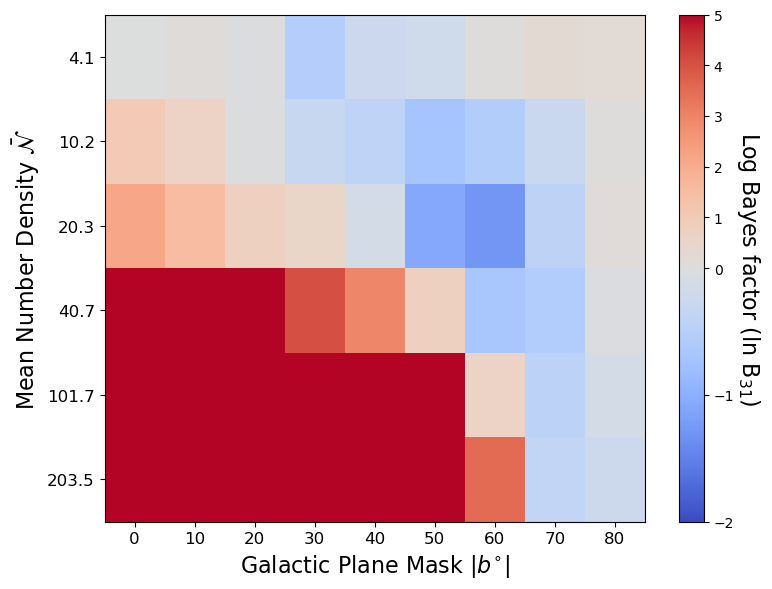

In [75]:
# Sort and map mask_angle and N_bar to consistent indices
mask_angles = sorted(bayes_factors['mask_angle'].unique())
N_bars = sorted(bayes_factors['N_bar'].unique())

# Create index mappings
mask_angle_to_idx = {val: idx for idx, val in enumerate(mask_angles)}
Nbar_to_idx = {val: idx + 1 for idx, val in enumerate(N_bars)}  # Start from 1 to match original structure

# Prepare values for plotting
x_vals = bayes_factors['mask_angle'].map(mask_angle_to_idx).values
y_vals = bayes_factors['N_bar'].map(Nbar_to_idx).values
weights = bayes_factors['B_31'].values

x_vals = np.array(x_vals)
y_vals = np.array(y_vals)
weights = np.array(weights)

# Define color normalization
vmin = -2
vmax = 5
norm = mcolors.TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)

# Define bin edges
x_min, x_max = min(x_vals), max(x_vals)
y_min, y_max = min(y_vals), max(y_vals)

plt.figure(figsize=(8, 6))
plt.hist2d(
    x_vals, y_vals,
    bins=[np.arange(x_min, x_max + 2, 1), np.arange(y_min, y_max + 2, 1)],
    weights=weights, cmap='coolwarm', norm=norm)

# Colorbar
cbar = plt.colorbar()
cbar.set_label(r'Log Bayes factor (ln B$_{31})$', rotation=270, labelpad=20, fontsize=16)
# ticks = [-2,-1, 0, 1,2,3,4,5]
# cbar.set_ticks(ticks)
# cbar.set_ticklabels([str(t) for t in ticks], fontsize=12)

# Axis labels and ticks
plt.xlabel(r'Galactic Plane Mask $|b^{\circ}|$', fontsize=16)
plt.ylabel(r'Mean Number Density $\bar{\mathcal{N}}$', fontsize=16)
plt.xticks(np.arange(x_min + 0.5, x_max + 1, 1), mask_angles, fontsize=12)
plt.yticks(np.arange(y_min + 0.5, y_max + 1, 1), N_bars, fontsize=12)
plt.gca().invert_yaxis()
plt.tight_layout()
# plt.savefig('../log_dir/Dipole_and_Quadrupole_Data/Masking/Ecliptic_Poles/Figures/bayes_factor_B31_comparison_matrix_averaged.png', dpi=300)
plt.show()

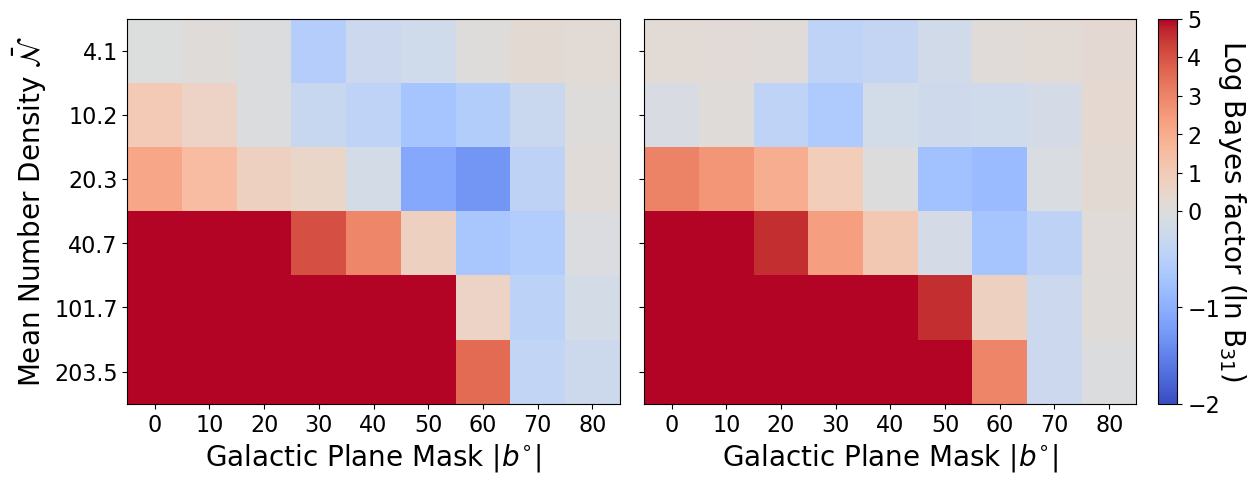

In [93]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Load data
bf1 = pd.read_csv('../log_dir/Dipole_and_Quadrupole_Data/Masking/masked_aligned_bayes_factors_file.csv')
bf2 = pd.read_csv('../log_dir/Dipole_and_Quadrupole_Data/Masking/masked_EP_bayes_factors_file.csv')

# Sort unique values for consistent indexing
mask_angles = sorted(bf1['mask_angle'].unique())
N_bars = sorted(bf1['N_bar'].unique())

# Create index mappings
mask_angle_to_idx = {val: idx for idx, val in enumerate(mask_angles)}
Nbar_to_idx = {val: idx + 1 for idx, val in enumerate(N_bars)}  # Start from 1

# Function to prepare x, y, weights arrays
def prepare_plot_data(bf, weight_column='B_31'):
    x_vals = bf['mask_angle'].map(mask_angle_to_idx).values
    y_vals = bf['N_bar'].map(Nbar_to_idx).values
    weights = bf[weight_column].values
    return np.array(x_vals), np.array(y_vals), np.array(weights)

x1, y1, w1 = prepare_plot_data(bf1)
x2, y2, w2 = prepare_plot_data(bf2)

# Define color normalization
vmin = -2
vmax = 5
norm = mcolors.TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)

# Define bin edges
x_edges = np.arange(min(mask_angle_to_idx.values()), max(mask_angle_to_idx.values()) + 2, 1)
y_edges = np.arange(1, len(N_bars) + 2, 1)
# Y-axis ticks at bin centers
y_centers = (y_edges[:-1] + y_edges[1:]) / 2
x_centers = (x_edges[:-1] + x_edges[1:]) / 2
# Create figure with 1 row, 2 columns
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True, gridspec_kw={'wspace':0.05})

# Left subplot
im1 = axes[0].hist2d(x1, y1, bins=[x_edges, y_edges], weights=w1, cmap='coolwarm', norm=norm)
axes[0].set_xlabel(r'Galactic Plane Mask $|b^{\circ}|$', fontsize=20)
axes[0].set_ylabel(r'Mean Number Density $\bar{\mathcal{N}}$', fontsize=20)
axes[0].set_xticks(x_centers)
axes[0].set_xticklabels(mask_angles, fontsize=16)
axes[0].set_yticks(y_centers)
axes[0].set_yticklabels(N_bars, fontsize=16)
axes[0].invert_yaxis()

# Right subplot
im2 = axes[1].hist2d(x2, y2, bins=[x_edges, y_edges], weights=w2, cmap='coolwarm', norm=norm)
axes[1].set_xlabel(r'Galactic Plane Mask $|b^{\circ}|$', fontsize=20)
axes[1].set_xticks(x_centers)
axes[1].set_xticklabels(mask_angles, fontsize=16)
# axes[1].set_yticks([])  # remove y ticks and label
axes[1].invert_yaxis()

# Shared colorbar
cbar = fig.colorbar(im1[3], ax=axes, orientation='vertical', fraction=0.05, pad=0.02)
cbar.set_label(r'Log Bayes factor (ln B$_{31}$)', rotation=270, labelpad=20, fontsize=20)
cbar.ax.tick_params(labelsize=16)
plt.savefig('../Thesis_images/combined_bayes_factors_EP_and_aligned_B31.pdf', dpi=300, bbox_inches='tight')

# plt.tight_layout()
plt.show()

In [94]:
mask_angles = [0,10,20,30,40,50,60,70,80]
N_bars = [4.1, 10.2, 20.3, 40.7, 101.7, 203.5]
true_D = 0.007
true_Q = 0.014
pathname = '../log_dir/Dipole_and_Quadrupole_Data/Masking/Ecliptic_Poles/'

# define 9 colours for the 9 masks
colors = ['darkviolet', 'royalblue', 'dodgerblue', 'teal', 'green', 
          'limegreen', 'orange', 'crimson', 'maroon']
alphas = [0.3, 0.5, 0.7, 0.9]
cmap = plt.get_cmap('plasma').copy()
cmap.set_bad('gray')

for N_bar in N_bars:
    #     # Read in the samples
    data = np.load(pathname+f'Datasets/skymap_data_Nbar_{N_bar}_0.npy',
                    allow_pickle=True).item()
    m = data['m']
    metadata = data['metadata']
    NSIDE = metadata['NSIDE']
    dipole_theta = metadata['d_vector'][0]
    dipole_phi = metadata['d_vector'][1]
    q_vector_1 = metadata['q_vector_1']
    q_vector_2 = metadata['q_vector_2']

    for mask_angle in mask_angles:
        m_plot, m_fit, fit_mask = mask_data(NSIDE, m, mask_angle)

    ### Skymaps
        dipole_quad_plotting(m_plot, d_vector=[dipole_theta, dipole_phi], q_vector_1=q_vector_1, q_vector_2=q_vector_2,
                        title='Density Map in Galactic Coordinates', unit="Sample Density",
                        cmap=cmap)
        plt.savefig(pathname+f'Figures/Skymaps/Unsmoothed/skymap_Nbar_{N_bar}_D_{true_D}_Q_{true_Q}_mask_{mask_angle}.png', dpi=300)
        plt.close()

        smooth_map = compute_smooth_map(m, angle_scale=1)
        smooth_map, m_fit, fit_mask = mask_data(NSIDE, smooth_map, mask_angle)

        dipole_quad_plotting(smooth_map, d_vector=[dipole_theta, dipole_phi], q_vector_1=q_vector_1, q_vector_2=q_vector_2,
                        title='Smooth Density Map in Galactic Coordinates', unit="Sample Density",
                        cmap=cmap)
        plt.savefig(pathname+f'Figures/Skymaps/Smoothed/smoothed_skymap_Nbar_{N_bar}_D_{true_D}_Q_{true_Q}_mask_{mask_angle}.png', dpi=300)
        plt.close()


    # ### CornerPlot
    #     # # select c as  the colour based on the index of the mask_angle
    #     c = colors[mask_angles.index(mask_angle)]

    #     # # Read in the samples
    #     # Take the average of the samples over the 20 iterations
    #     samples = np.zeros((0, 9))  # Assuming 9 parameters: N_bar, D, Q, l, b, l1, b1, l2, b2
    #     for i in range(20):
    #         sample_i = np.loadtxt(pathname + f'/Dipole_Quadrupole_model/Nbar_{N_bar}/Nbar_{N_bar}_mask_{mask_angle}_iteration_{i}/chains/equal_weighted_post.txt', skiprows=1)
    #         samples = np.vstack((samples, sample_i))
            
    # # # Corner plot
    #     corner.corner(samples,
    #                         labels=[r'$\bar N$', 'D', 'Q', r'$l$', r'$b$', r'$l_1$', r'$b_1$', r'$l_2$', r'$b_2$'],
    #                         truths=[N_bar, true_D, true_Q, 2*np.pi - np.radians(96), np.radians(48),
    #                                 2*np.pi - np.radians(96), np.radians(48),2*np.pi - np.radians(96), np.radians(48)],
    #                         truth_color='r')
    #     plt.savefig(pathname+f'Figures/Cornerplots/Dipole_Quadrupole/cornerplot_Nbar_{N_bar}_D_{true_D}_Q_{true_Q}_mask_{mask_angle}_averaged.png', dpi=300)
    #     # plt.show()
    #     plt.close()
        
    # ### Dipole amplitude posterior
    #     D_data = samples[:,1]
    #     Q_data = samples[:,2]

    #     plt.figure(figsize=(4,4))
    #     corner.corner(D_data, labels=["$D$"], show_titles=False,
    #                             title_fmt=".4f", quantiles=[0.5, 0.5, 0.5],
    #                             title_kwargs={"fontsize": 10},
    #                     color="k",  # color for median line and edges
    #                     hist_kwargs={"alpha": 0.9, "color": c, "edgecolor": "k", "linewidth": 1.5, "histtype": "stepfilled"},
    #                     smooth1d_kwargs={"color": c, "alpha": 0.6})

    #     plt.axvline(true_D, color='red', linestyle='--', label='True D', linewidth=1.5)
    #     plt.tight_layout()

    #     plt.savefig(pathname+f'Figures/Amplitude_Posteriors/D/D_distribution_Nbar_{N_bar}_D_{true_D}_Q_{true_Q}_mask_{mask_angle}_averaged.png', dpi=300)
    #     plt.close()
        
    #     plt.figure(figsize=(4,4))
    #     corner.corner(Q_data, labels=["$Q$"], show_titles=False,
    #                             title_fmt=".4f", quantiles=[0.5, 0.5, 0.5],
    #                             title_kwargs={"fontsize": 10},
    #                     color="k",  # color for median line and edges
    #                     hist_kwargs={"alpha": 0.9, "color": c, "edgecolor": "k", "linewidth": 1.5, "histtype": "stepfilled"},
    #                     smooth1d_kwargs={"color": c, "alpha": 0.6})

    #     plt.axvline(true_Q, color='red', linestyle='--', label='True Q', linewidth=1.5)
    #     plt.tight_layout()

    #     plt.savefig(pathname+f'Figures/Amplitude_Posteriors/Q/Q_distribution_Nbar_{N_bar}_D_{true_D}_Q_{true_Q}_mask_{mask_angle}_averaged.png', dpi=300)
    #     plt.close()
        
    #     l, b = samples[:, 3], samples[:, 4]
    #     l1, b1, l2, b2 = samples[:, 5], samples[:, 6], samples[:, 7], samples[:, 8]
    #     smooth_sigma = 0.1
    #     NSIDE = 64

    #     smooth_map = process_vector_component(l, b, NSIDE, smooth_sigma)
    #     smooth_map1 = process_vector_component(l1, b1, NSIDE, smooth_sigma)
    #     smooth_map2 = process_vector_component(l2, b2, NSIDE, smooth_sigma)

    #     X, Y, P_xy, t_contours = get_projection_and_contours(smooth_map)
    #     X1, Y1, P_xy1, t_contours1 = get_projection_and_contours(smooth_map1)
    #     X2, Y2, P_xy2, t_contours2 = get_projection_and_contours(smooth_map2)

    #     alphas = [0.3, 0.5, 0.7, 0.9]
    #     c, c1, c2 = 'gray', 'orange', 'darkcyan'

    #     empty_map = np.full(hp.nside2npix(64), np.nan)
    #     hp.projview(empty_map, cmap="Blues", graticule=True, graticule_labels=True, min=0, max=1, cbar=None)   

    #     # Fixing the range of longitudes for plotting, annoying!!
    #     if q_vector_1[1] > np.pi:
    #         q_vector_1[1] = q_vector_1[1]- 2*np.pi
    #     if q_vector_2[1] > np.pi:
    #         q_vector_2[1] = q_vector_2[1]- 2*np.pi  

    #     cs1 = plt.contour(X, Y, P_xy, levels=t_contours, colors='crimson', linewidths=2.5)
    #     cs2 = plt.contour(X1, Y1, P_xy1, levels=t_contours1, colors='orange', linewidths=2.5)
    #     cs3 = plt.contour(X2, Y2, P_xy2, levels=t_contours2, colors='darkcyan', linewidths=2.5)

    #     newprojplot(theta=dipole_theta, phi=dipole_phi, marker="*", color="k", markersize=20, zorder=5)
    #     newprojplot(theta=q_vector_1[0], phi=q_vector_1[1], marker="*", color="k", markersize=20, zorder=5)
    #     newprojplot(theta=q_vector_2[0], phi=q_vector_2[1], marker="*", color="k", markersize=20, zorder=5)
    
    #     plt.savefig(pathname+f'Figures/Contour_Distributions/contour_Nbar_{N_bar}_D_{true_D}_Q_{true_Q}_mask_{mask_angle}_averaged.png', dpi=300)
    #     plt.close()
    #     # break
    # # break

In [92]:
mask_angles = [0, 10, 20, 30, 40, 50, 60, 70, 80]
N_bars = [4.1, 10.2, 20.3, 40.7, 101.7, 203.5] 
true_D = 0.007
true_Q = 0.014
pathname = '../log_dir/Dipole_and_Quadrupole_Data/Masking/Ecliptic_Poles/'

# Define 9 colours for the 9 masks
colors = ['darkviolet', 'royalblue', 'dodgerblue', 'teal', 'green',
          'limegreen', 'orange', 'crimson', 'maroon']

for N_bar in N_bars:

    fig1, axs1 = plt.subplots(3, 3, figsize=(10, 6), sharex=False, sharey=False)
    axs1 = axs1.flatten()

    fig2, axs2 = plt.subplots(3, 3, figsize=(10, 6), sharex=False, sharey=False)
    axs2 = axs2.flatten()

    for i, mask_angle in enumerate(mask_angles):
        c = colors[i]
        samples = np.zeros((0, 9))  # Assuming 9 parameters: N_bar, D, Q, l, b, l1, b1, l2, b2

        for j in range(20):
            sample_path = (pathname +
                f'Dipole_Quadrupole_model/Nbar_{N_bar}/'
                f'Nbar_{N_bar}_mask_{mask_angle}_iteration_{j}/chains/equal_weighted_post.txt')
            if os.path.exists(sample_path):
                sample_i = np.loadtxt(sample_path, skiprows=1)
                samples = np.vstack((samples, sample_i))

        if samples.shape[0] == 0:
            continue  # skip if no samples

        D_data = samples[:, 1]
        Q_data = samples[:, 2]

        # ---------------- Dipole hist ----------------
        ax1 = axs1[i]
        ax1.hist(D_data, bins=30, density=True,
                 color=c, edgecolor=c, linewidth=0.8,
                 histtype='stepfilled', alpha=0.6)
        ax1.hist(D_data, bins=30, density=True,
                 histtype='step', color=c, linewidth=2.0)

        ax1.axvline(np.median(D_data), color='k', linestyle='--', linewidth=2)
        ax1.axvline(true_D, color='r', linestyle='--', linewidth=2)

        ax1.set_title(rf"$g^\circ_{{\mathrm{{mask}}}}$ = {mask_angle}", fontsize=12)
        ax1.set_yticks([])
        ax1.set_xlim(0, 0.03)

        if i >= 6:  # bottom row
            ax1.set_xticks([0.0, 0.01, 0.02, 0.03])
            ax1.tick_params(axis='x', labelsize=9)
        else:
            ax1.tick_params(axis='x', labelbottom=False)

        # ---------------- Quadrupole hist ----------------
        ax2 = axs2[i]
        ax2.hist(Q_data, bins=30, density=True,
                 color=c, edgecolor=c, linewidth=0.8,
                 histtype='stepfilled', alpha=0.6)
        ax2.hist(Q_data, bins=30, density=True,
                 histtype='step', color=c, linewidth=2.0)

        ax2.axvline(np.median(Q_data), color='k', linestyle='--', linewidth=2)
        ax2.axvline(true_Q, color='r', linestyle='--', linewidth=2)

        ax2.set_title(rf"$g^\circ_{{\mathrm{{mask}}}}$ = {mask_angle}", fontsize=12)
        ax2.set_yticks([])
        ax2.set_xlim(0, 0.06)

        if i >= 6:  # bottom row
            ax2.set_xticks([0.0, 0.02, 0.04, 0.06])
            ax2.tick_params(axis='x', labelsize=9)
        else:
            ax2.tick_params(axis='x', labelbottom=False)

    # Remove any unused subplot axes
    for j in range(len(mask_angles), len(axs1)):
        fig1.delaxes(axs1[j])
    for j in range(len(mask_angles), len(axs2)):
        fig2.delaxes(axs2[j])

    # Shared labels + suptitle
    fig1.text(0.51, 0.03, r'Dipole Amplitude $\mathcal{D}$', ha='center', fontsize=16)
    fig1.text(0.09, 0.5, 'Probability Density', va='center', rotation='vertical', fontsize=16)
    fig1.suptitle(rf'Dipole Amplitude Posterior: $\bar{{N}}$ = {N_bar}', fontsize=20, y=0.99)

    fig2.text(0.51, 0.03, r'Quadrupole Amplitude $\mathcal{Q}$', ha='center', fontsize=16)
    fig2.text(0.09, 0.5, 'Probability Density', va='center', rotation='vertical', fontsize=16)
    fig2.suptitle(rf'Quadrupole Amplitude Posterior: $\bar{{N}}$ = {N_bar}', fontsize=20, y=0.99)

    fig1.savefig(pathname + f'Figures/Amplitude_Posteriors/Combined/combined_D_distributions_Nbar_{N_bar}_averaged.png', dpi=300)
    fig2.savefig(pathname + f'Figures/Amplitude_Posteriors/Combined/combined_Q_distributions_Nbar_{N_bar}_averaged.png', dpi=300)
    
    plt.close(fig1)
    plt.close(fig2)
    # plt.show()
    # break

In [93]:
mask_angles = [0, 10, 20, 30, 40, 50, 60, 70, 80]
N_bars = [4.1, 10.2, 20.3, 40.7, 101.7, 203.5] 
true_D = 0.007
true_Q = 0.014
pathname = '../log_dir/Dipole_and_Quadrupole_Data/Masking/Ecliptic_Poles/'

# Define 9 colours for the 9 masks
colors = ['darkviolet', 'royalblue', 'dodgerblue', 'teal', 'green',
          'limegreen', 'orange', 'crimson', 'maroon']

for N_bar in N_bars:

    fig, axs = plt.subplots(3, 3, figsize=(10, 6), sharex=False, sharey=False)
    axs = axs.flatten()

    for i, mask_angle in enumerate(mask_angles):
        samples = np.zeros((0, 9))  # Assuming 9 parameters: N_bar, D, Q, l, b, l1, b1, l2, b2

        for j in range(20):
            sample_path = (pathname +
                f'Dipole_Quadrupole_model/Nbar_{N_bar}/'
                f'Nbar_{N_bar}_mask_{mask_angle}_iteration_{j}/chains/equal_weighted_post.txt')
            if os.path.exists(sample_path):
                sample_i = np.loadtxt(sample_path, skiprows=1)
                samples = np.vstack((samples, sample_i))

        if samples.shape[0] == 0:
            continue  # skip if no samples

        D_data = samples[:, 1]
        Q_data = samples[:, 2]

        ax = axs[i]

        # ----- Dipole histogram -----
        ax.hist(D_data, bins=30, density=True,
                color="royalblue", edgecolor="royalblue", linewidth=0.8,
                histtype='stepfilled', alpha=0.4, label=r"Dipole $\mathcal{D}$" if i == 0 else "")
        ax.hist(D_data, bins=30, density=True,
                histtype='step', color="royalblue", linewidth=2.0)
        
        # ----- Quadrupole histogram -----
        ax.hist(Q_data, bins=30, density=True,
                color="crimson", edgecolor="crimson", linewidth=0.8,
                histtype='stepfilled', alpha=0.4, label=r"Quadrupole $\mathcal{Q}$" if i == 0 else "")
        ax.hist(Q_data, bins=30, density=True,
                histtype='step', color="crimson", linewidth=2.0)

        # ----- Medians and truths -----
        ax.axvline(true_D, color='blue', linestyle='--', linewidth=2, label=r'True $\mathcal{D}$')
        ax.axvline(true_Q, color='red', linestyle='--', linewidth=2, label=r'True $\mathcal{Q}$')

        ###  Turned off atm because it is hard to see/distinguish. Might turn back on and change colour later
        # ax.axvline(np.median(D_data), color='blue', linestyle=':', linewidth=2, label=r'Median $\mathcal{D}$')
        # ax.axvline(np.median(Q_data), color='red', linestyle=':', linewidth=2, label=r'Median $\mathcal{Q}$')

        # Formatting
        ax.set_title(rf"$g^\circ_{{\mathrm{{mask}}}}$ = {mask_angle}", fontsize=12)
        ax.set_yticks([])
        ax.set_xlim(0, 0.06)  # wide enough to include both D and Q

        if i >= 6:  # bottom row
            ax.set_xticks([0.0, 0.02, 0.04, 0.06])
            ax.tick_params(axis='x', labelsize=9)
        else:
            ax.tick_params(axis='x', labelbottom=False)

    # Remove unused axes
    for j in range(len(mask_angles), len(axs)):
        fig.delaxes(axs[j])

    # Shared labels + suptitle
    fig.text(0.51, 0.03, r'Amplitude', ha='center', fontsize=16)
    fig.text(0.09, 0.5, 'Probability Density', va='center', rotation='vertical', fontsize=16)
    fig.suptitle(rf'Dipole vs Quadrupole Posteriors: $\bar{{N}}$ = {N_bar}', fontsize=20, y=0.99)

    # Shared legend underneath all subplots
    handles, labels = axs[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc="lower center", fontsize=12,
               ncol=2, frameon=True, bbox_to_anchor=(0.5, -0.1))

    # Save + show
    fig.savefig(pathname+ f"Figures/Amplitude_Posteriors/Combined/Combined_Posterior_Nbar_{N_bar}.png", dpi=300, bbox_inches='tight')
    plt.close()
    # break

In [ ]:
import os
import fitz  # PyMuPDF

input_folder = "../log_dir/Dipole_and_Quadrupole_Data/Masking/Ecliptic_Poles/Figures/Contour_Distributions/"        # folder with your PDFs
output_folder = "../log_dir/Dipole_and_Quadrupole_Data/Masking/Ecliptic_Poles/Figures/Contour_Distributions/Figures_Cropped"
os.makedirs(output_folder, exist_ok=True)

top_bottom_crop_fraction = 0.10  # 10% from top and bottom

for filename in os.listdir(input_folder):
    if filename.lower().endswith(".pdf"):
        input_path = os.path.join(input_folder, filename)
        output_path = os.path.join(output_folder, filename)

        doc = fitz.open(input_path)
        for page in doc:
            rect = page.rect  # original bounding box
            height = rect.height

            # Compute new crop box
            new_rect = fitz.Rect(
                rect.x0,
                rect.y0 + height * top_bottom_crop_fraction,   # crop bottom 10%
                rect.x1,
                rect.y1 - height * top_bottom_crop_fraction    # crop top 10%
            )
            page.set_cropbox(new_rect)

        doc.save(output_path)
        doc.close()

print(f"✅ Cropped PDFs saved in '{output_folder}'")

In [13]:
import os
from PIL import Image  # Pillow

input_folder = "../log_dir/Dipole_and_Quadrupole_Data/Masking/Ecliptic_Poles/Figures/Contour_Distributions/"
output_folder = "../log_dir/Dipole_and_Quadrupole_Data/Masking/Ecliptic_Poles/Figures/Contour_Distributions/Figures_Cropped"
os.makedirs(output_folder, exist_ok=True)

top_bottom_crop_fraction = 0.10  # 10% from top and bottom

for filename in os.listdir(input_folder):
    if filename.lower().endswith(".png"):
        input_path = os.path.join(input_folder, filename)
        output_path = os.path.join(output_folder, filename)

        img = Image.open(input_path)
        width, height = img.size

        # Compute pixel crop bounds
        top = int(height * top_bottom_crop_fraction)
        bottom = int(height * (1 - top_bottom_crop_fraction))

        cropped_img = img.crop((0, top, width, bottom))  # (left, upper, right, lower)
        cropped_img.save(output_path)

print(f"✅ Cropped PNGs saved in '{output_folder}'")

✅ Cropped PNGs saved in '../log_dir/Dipole_and_Quadrupole_Data/Masking/Ecliptic_Poles/Figures/Contour_Distributions/Figures_Cropped'


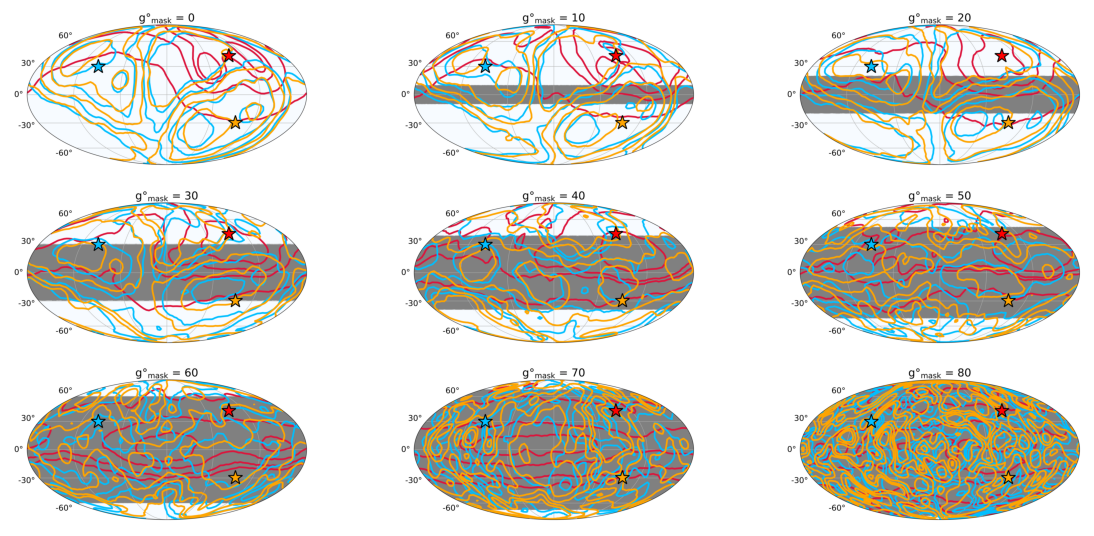

In [14]:
import os
import fitz  # PyMuPDF
import numpy as np
import matplotlib.pyplot as plt

folder_path = '../log_dir/Dipole_and_Quadrupole_Data/Masking/Ecliptic_Poles/Figures/Contour_Distributions/Figures_Cropped'

Nbars = [4.1, 10.2, 20.3, 40.7, 101.7, 203.5]
mask_angles = [0, 10, 20, 30, 40, 50, 60, 70, 80]

for Nbar in Nbars:
    pdf_images = []
    for mask_angle in mask_angles:
        filename = f'contour_Nbar_{Nbar}_D_0.007_Q_0.014_mask_{mask_angle}_averaged.pdf'
        filepath = os.path.join(folder_path, filename)

        if not os.path.exists(filepath):
            print(f"Warning: Missing file: {filename}")
            pdf_images.append(None)
            continue

        # Open and render PDF page as an image
        doc = fitz.open(filepath)
        page = doc[0]
        pix = page.get_pixmap(dpi=300)
        img = np.frombuffer(pix.samples, dtype=np.uint8).reshape(pix.height, pix.width, pix.n)
        if img.shape[2] == 4:  # drop alpha if present
            img = img[..., :3]
        pdf_images.append(img)
        doc.close()

    # Tighter layout with minimal white space
    fig, axes = plt.subplots(
        3, 3,
        figsize=(12, 6),
        gridspec_kw={"wspace": 0.02, "hspace": 0.1}  # very small gaps
    )
    # fig.suptitle(fr'$\bar{{\mathcal{{N}}}} = {Nbar}$', fontsize=16)

    for ax, img, mask_angle in zip(axes.flat, pdf_images, mask_angles):
        if img is not None:
            ax.imshow(img)
        ax.axis('off')
        # ax.set_title(fr"$g^\circ_{{\mathrm{{mask}}}}$ = {mask_angle}", fontsize=11, pad=2)

    plt.subplots_adjust(left=0.02, right=0.98, top=0.88, bottom=0.02)
    plt.show()
    plt.close()
    break

In [47]:
def dipole_quad_plotting(m, d_vector=None, q_vector_1=None, q_vector_2=None, title=None, unit=None, cmap='plasma'):
    projview(m, title=title, unit=unit,
    graticule=True, graticule_labels=True, projection_type="mollweide", cmap=cmap, fontsize={'cbar_tick_label':16});
    # adjusting the angles to be in the range [-pi, pi] for plotting
    if q_vector_1[1] > np.pi:
        q_vector_1[1] = q_vector_1[1]- 2*np.pi
    if q_vector_2[1] > np.pi:
        q_vector_2[1] = q_vector_2[1]- 2*np.pi  
    newprojplot(theta=d_vector[0], phi=d_vector[1], marker="*", color="b", markersize=30);
    newprojplot(theta=q_vector_1[0], phi=q_vector_1[1], marker="*", color="lightseagreen", markersize=30);
    newprojplot(theta=q_vector_2[0], phi=q_vector_2[1], marker="*", color="lightseagreen", markersize=30);
    # plt.tight_layout()

    # increase fontsize of graticule labels
    plt.tick_params(axis='both', which='major', labelsize=16)

    return

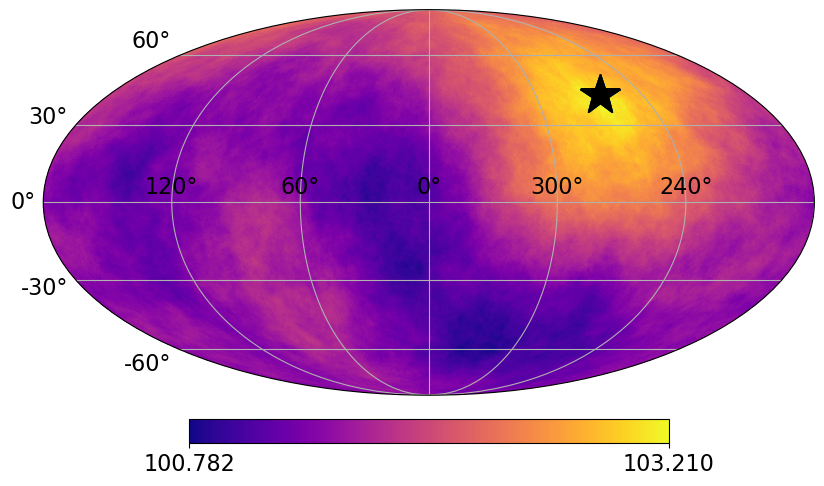

In [68]:

NSIDE = 64
NPIX = hp.nside2npix(NSIDE)
D = 0.007
Q = 0.014
N_bar = 101.7
dipole_theta = np.deg2rad(48) # CMB Directions (b)
dipole_phi = -np.deg2rad(360-264) # (l)
# Set the quadrupole vectors to both point at the ecliptic poles
q_vector_1 = [np.deg2rad(90-29.81), np.deg2rad(96.38)]  # b1, l1 north ecliptic pole
q_vector_2 = [np.deg2rad(90+29.81), np.deg2rad(-96.38)]  # b2, l2 south ecliptic pole
q_vector_1 = [dipole_theta, dipole_phi]
q_vector_2 = [dipole_theta, dipole_phi]

mask_angles = [0,10,20,30,40,50,60,70,80]

np.random.seed(42)
m, lambda_ = dipole_quad_sampling(NSIDE, N_bar=N_bar, D=D, Q=Q,
                                d_vector=[dipole_theta, dipole_phi],
                                q_vector_1=q_vector_1, q_vector_2=q_vector_2)
cmap = plt.get_cmap('plasma').copy()
cmap.set_bad('gray')

for mask_angle in mask_angles:
    m_plot, m_fit, fit_mask = mask_data(NSIDE, m, mask_angle)
    smooth_map = compute_smooth_map(m, angle_scale=1)
    smooth_map, m_fit, fit_mask = mask_data(NSIDE, smooth_map, mask_angle)

    dipole_quad_plotting(smooth_map, d_vector=[dipole_theta, dipole_phi], q_vector_1=q_vector_1, q_vector_2=q_vector_2, cmap=cmap)
    # newprojplot(theta=dipole_theta, phi=dipole_phi, marker="*", color="b", markersize=15)
    # newprojplot(theta=q_vector_1[0], phi=q_vector_1[1], marker="*", color="lightseagreen", markersize=30)
    # newprojplot(theta=q_vector_2[0], phi=q_vector_2[1], marker="*", color="lightseagreen", markersize=30)
    newprojplot(theta=dipole_theta, phi=dipole_phi, marker="*", color="k", markersize=15)
    newprojplot(theta=q_vector_1[0], phi=q_vector_1[1], marker="*", color="k", markersize=30)
    newprojplot(theta=q_vector_2[0], phi=q_vector_2[1], marker="*", color="k", markersize=30)
    # plt.tight_layout()
    plt.savefig(f'../Thesis_images/masked_skymap_smoothed_Nbar_{N_bar}_D_{D}_Q_{Q}_mask_{mask_angle}_aligned.pdf', dpi=300)
    plt.show()
    break

In [69]:
import fitz  # PyMuPDF
import os

# Directory containing your PDFs
input_dir = "../Thesis_images"
output_dir = "../Thesis_images/cropped"
os.makedirs(output_dir, exist_ok=True)

# Amount to crop from each edge (in points; 72 pt = 1 inch)
crop_left = 5
crop_right = 15
crop_top = 15
crop_bottom = 30

# Masks to loop over
masks = [0, 10, 20, 30, 40, 50, 60, 70, 80]
masks = [0]
for mask in masks:
    filename = f"masked_skymap_smoothed_Nbar_101.7_D_0.007_Q_0.014_mask_{mask}_aligned.pdf"
    input_path = os.path.join(input_dir, filename)
    output_path = os.path.join(output_dir, filename)

    doc = fitz.open(input_path)
    page = doc[0]

    # Get the original rectangle
    rect = page.rect

    # Define a new cropped rectangle
    new_rect = fitz.Rect(
        rect.x0 + crop_left,
        rect.y0 + crop_top,
        rect.x1 - crop_right,
        rect.y1 - crop_bottom
    )

    # Apply the crop
    page.set_cropbox(new_rect)

    # Save cropped version
    doc.save(output_path)
    doc.close()

    print(f"Cropped and saved: {output_path}")

print("✅ All PDFs cropped and saved to", output_dir)

Cropped and saved: ../Thesis_images/cropped/masked_skymap_smoothed_Nbar_101.7_D_0.007_Q_0.014_mask_0_aligned.pdf
✅ All PDFs cropped and saved to ../Thesis_images/cropped


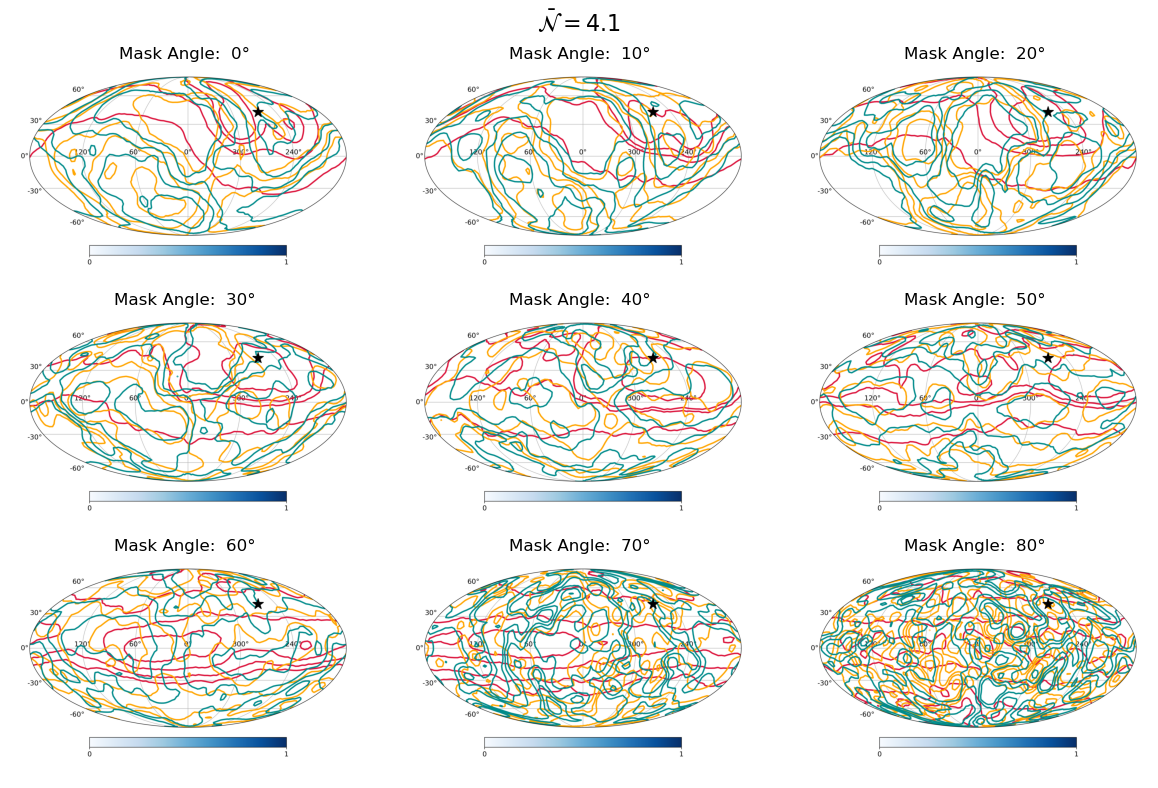

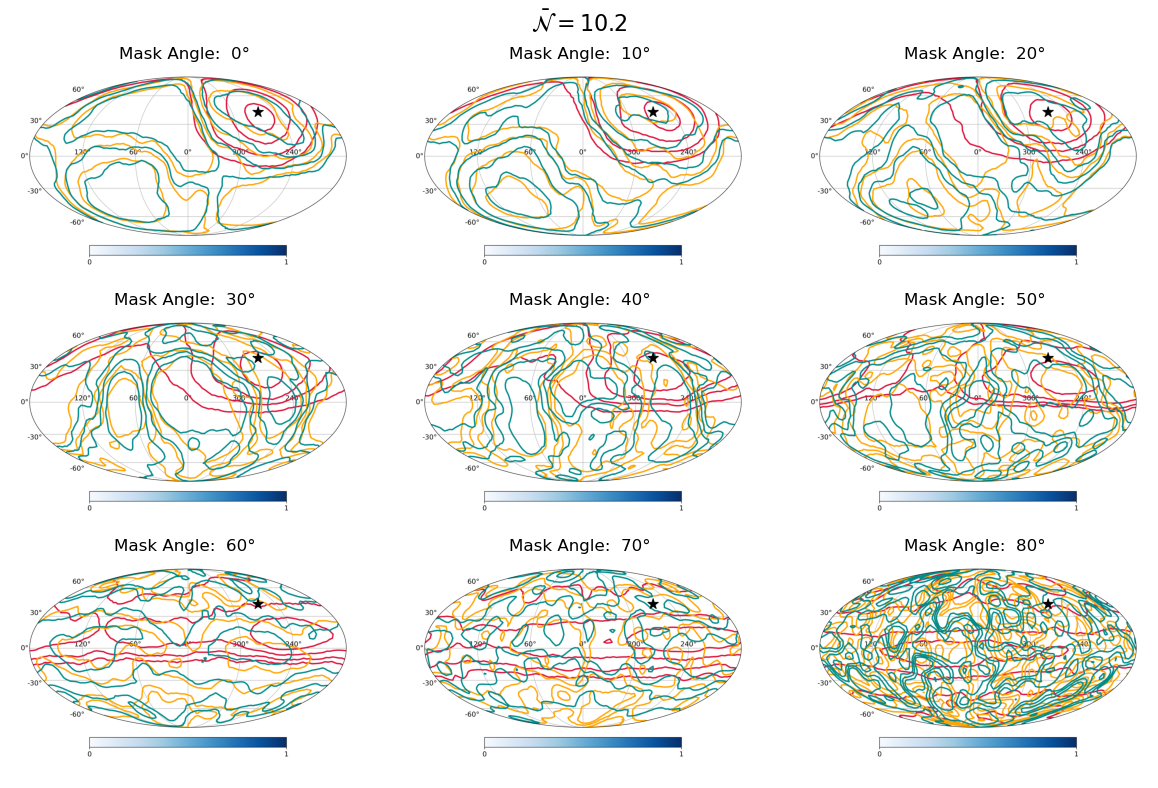

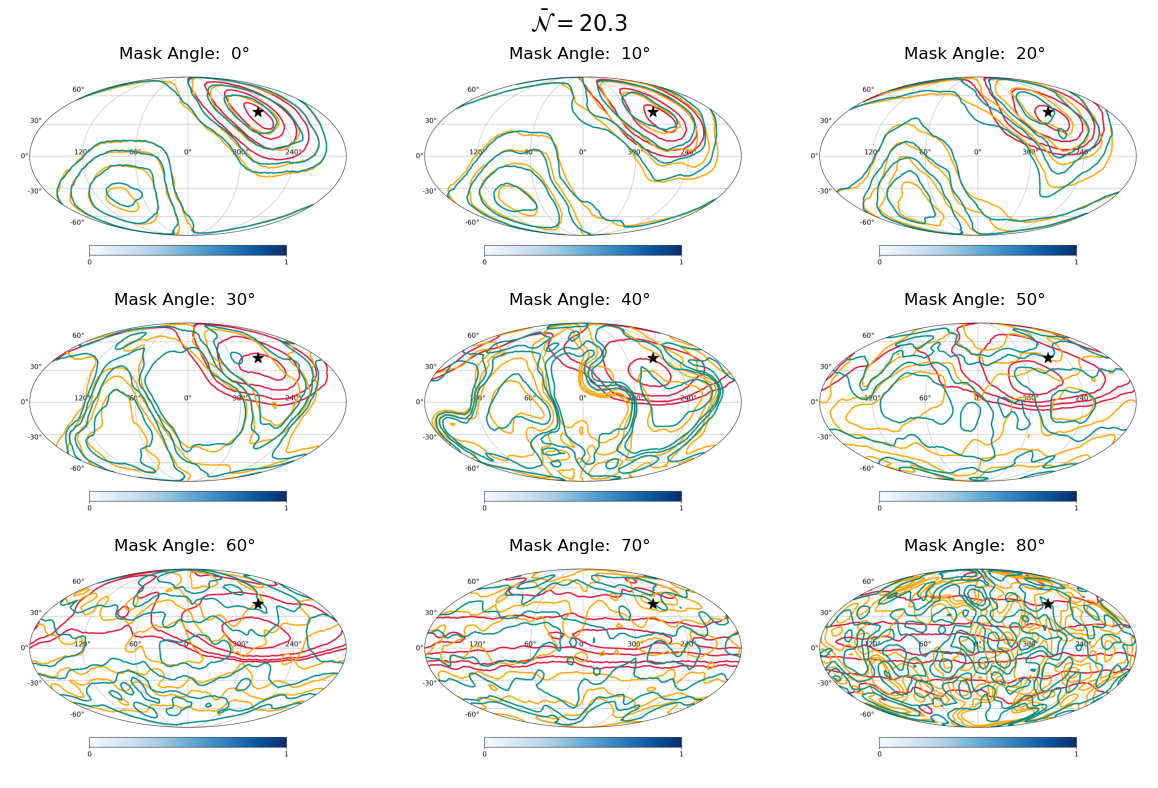

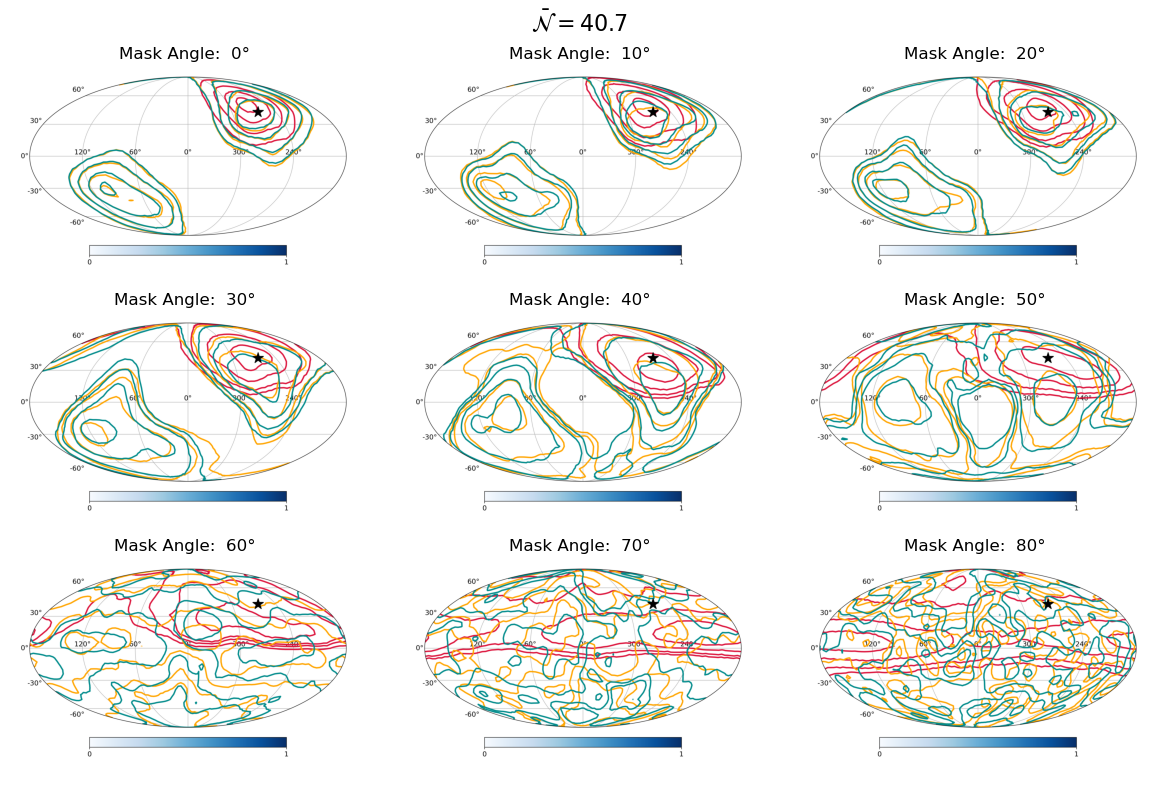

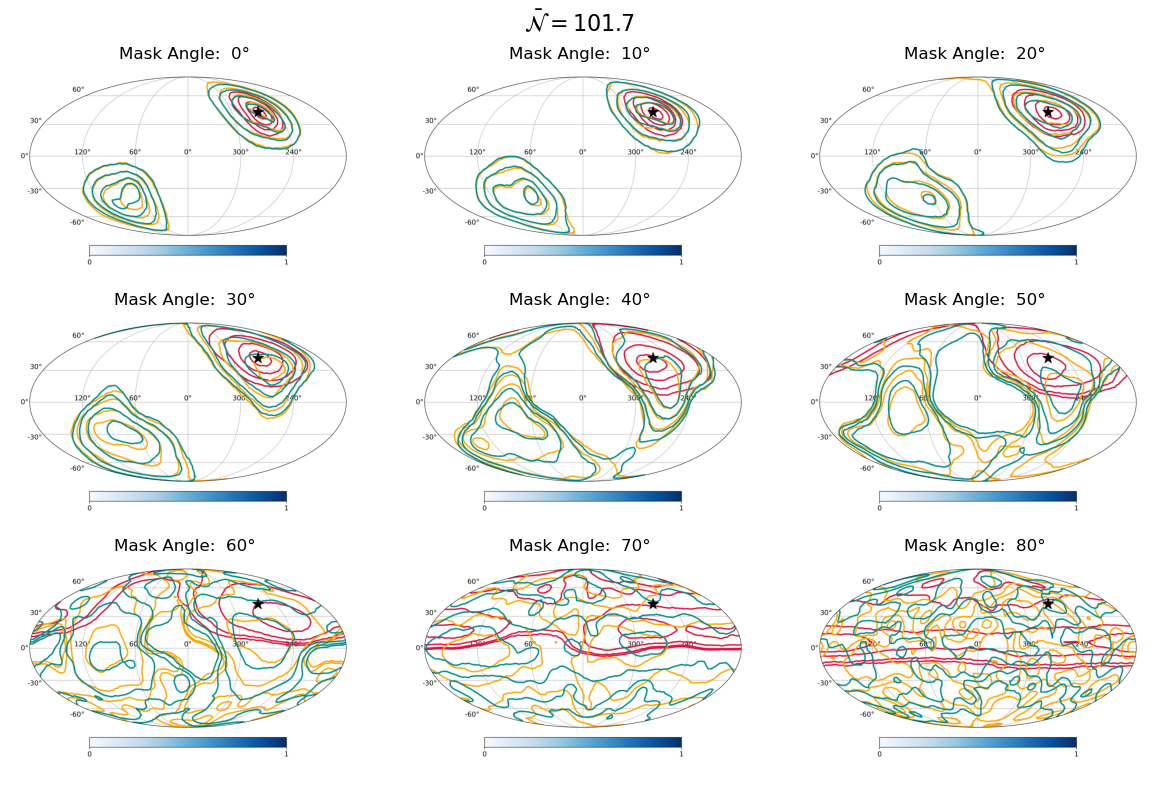

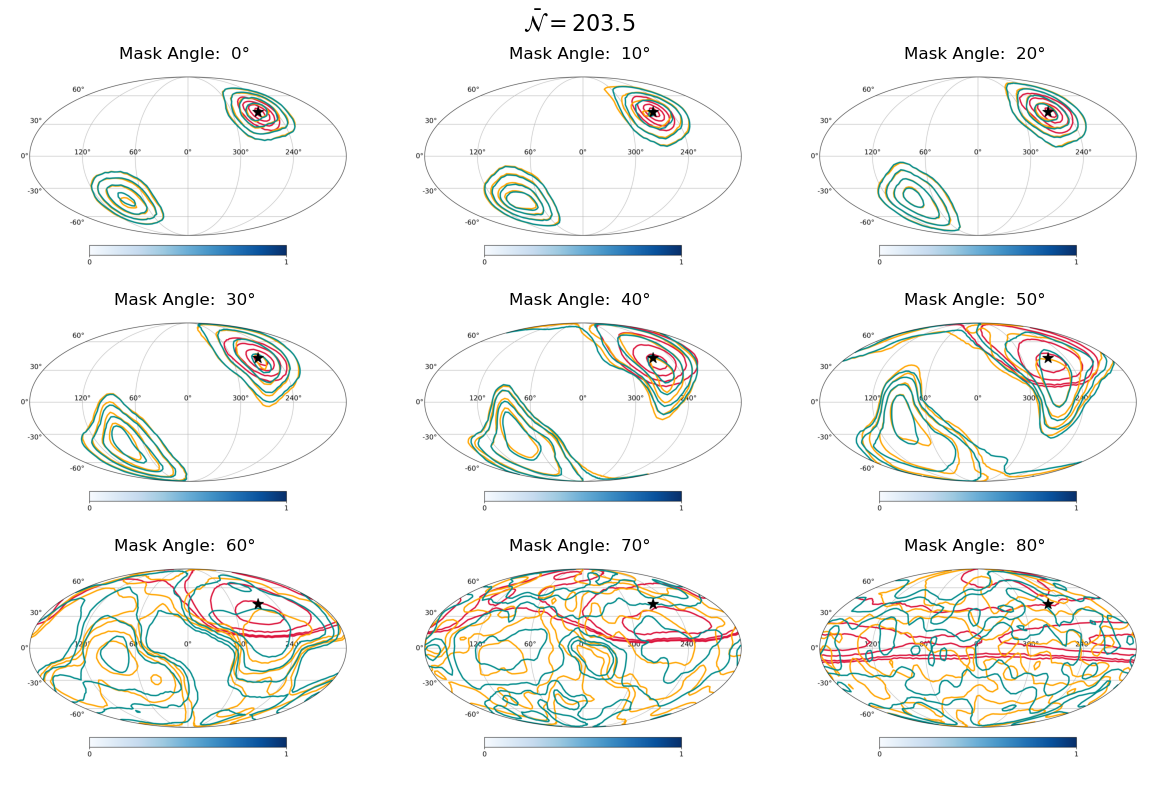

In [13]:
import os
import matplotlib.image as mpimg
folder_path = '../log_dir/Dipole_and_Quadrupole_Data/Masking/Figures/Contour_Distributions/'

Nbars = [4.1, 10.2, 20.3, 40.7, 101.7, 203.5]
mask_angles = [0,10,20,30,40,50,60,70,80]

for Nbar in Nbars:
    image_files = [f'contour_Nbar_{Nbar}_D_0.007_Q_0.014_mask_{mask_angle}_averaged.png' for mask_angle in mask_angles]

    missing_files = [f for f in image_files if not os.path.exists(os.path.join(folder_path, f))]
    if missing_files:
        print(f'Warning: Missing images for mask angle = {mask_angle}: {missing_files}')


    fig, axes = plt.subplots(3, 3, figsize=(12, 8))
    fig.suptitle(fr'$\bar{{\mathcal{{N}}}} = {Nbar}$', fontsize=16)

    for ax, img_file, mask_angle in zip(axes.flat, image_files, mask_angles):
        img = mpimg.imread(os.path.join(folder_path, img_file))
        ax.imshow(img)
        ax.axis('off') 


        ax.set_title(r'Mask Angle: ' + f' {mask_angle}°', fontsize=12)

    plt.tight_layout()
    plt.savefig(folder_path+f'/combined_masked_distributions_nbar_{Nbar}.png', dpi=300)
    plt.show()
    plt.close()
    


# Looking at Calculating the KL Divergence 

In [352]:
import numpy as np
import json

results = []

N_bars = [1, 5, 10, 20, 40, 60, 80, 100]
mask_angles = [0,10,20,30,40,50,60,70,80]
for N_bar in N_bars:
    for mask_angle in mask_angles:
        D_KL = []
        for i in range(20):  # Loop through iterations
            log_dir = f'../log_dir/Dipole_data/Masking/Dipole_model/Nbar_{N_bar}/Nbar_{N_bar}_mask_{mask_angle}_iteration_{i}/'  # change to your actual log directory
            chains_dir = log_dir + 'chains/'


            # 1. Load log-likelihoods and weights
            #    Columns: param1, param2, ..., logl, weight
            data = np.loadtxt(chains_dir + 'weighted_post.txt', skiprows=1)
            logl = data[:, 1]    
            weights = data[:, 0] 
            weights /= np.sum(weights)

            # 2. Load logZ from results
            with open(log_dir + 'info/results.json', 'r') as f:
                result = json.load(f)
            logZ = result['logz']
            if not np.isfinite(logZ):
                print(f"Bad logZ at N_bar={N_bar}, mask_angle={mask_angle}")
                continue

            # 3. Compute KL divergence
            logL_mean = np.sum(weights * logl)
            D_KL_i = logL_mean - logZ
            D_KL.append(D_KL_i)
        D_KL = np.mean(D_KL)
        # Add the results to a dataframe
        results.append({
            'N_bar': N_bar,
            'Mask Angle': mask_angle,
            'Average KL Divergence': D_KL
        })

results_df = pd.DataFrame(results)
results_df


N_bar  Mask Angle  Average KL Divergence
0       1           0              10.757552
1       1          10              10.602157
2       1          20              10.365184
3       1          30              10.058522
4       1          40               9.657194
..    ...         ...                    ...
67    100          40              11.514059
68    100          50              10.512422
69    100          60               9.224017
70    100          70               7.967399
71    100          80               6.015526

[72 rows x 3 columns]

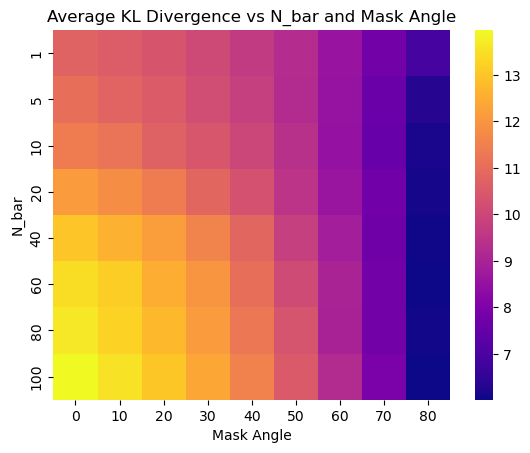

In [354]:
import seaborn as sns

pivot = results_df.pivot(index='N_bar', columns='Mask Angle', values='Average KL Divergence')
sns.heatmap(pivot, annot=False, cmap='plasma')
plt.title('Average KL Divergence vs N_bar and Mask Angle')
plt.show()

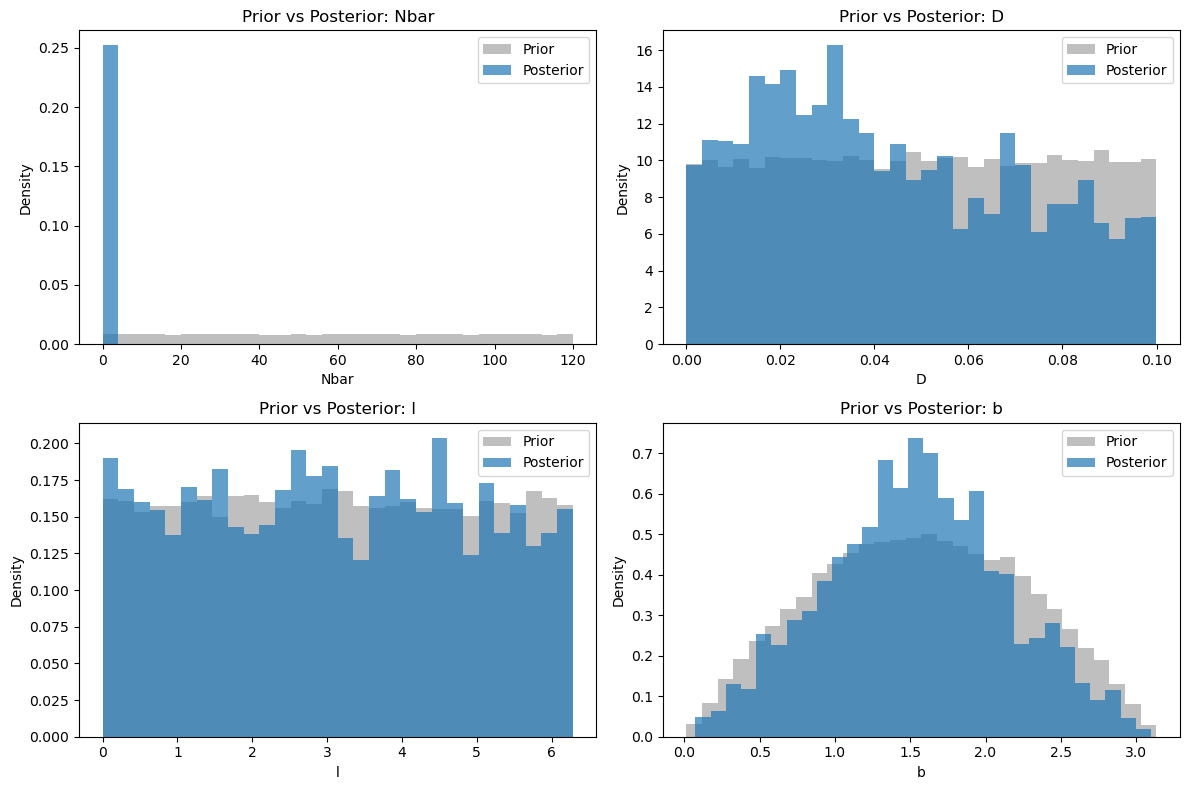

In [295]:
import numpy as np
import matplotlib.pyplot as plt

# === 1. Set paths ===
log_dir = '../log_dir/Dipole_data/Masking/Dipole_model/Nbar_1/Nbar_1_mask_80_iteration_0/'
chains_dir = log_dir + 'chains/'

# === 2. Load posterior samples and weights ===
# weighted_post.txt: columns = weight, logl, Nbar, D, l, b
data = np.loadtxt(chains_dir + 'weighted_post.txt', skiprows=1)
weights = data[:, 0]
posterior_samples = data[:, 2:]  # Nbar, D, l, b
weights /= np.sum(weights)  # Normalize

# === 3. Define the prior transform ===
def prior_transform(cube):
    N_bar = cube[0]*120
    D = cube[1]/10
    l = cube[2]*2*np.pi
    c = cube[3]
    b = np.arccos(np.clip(1 - 2*c, -1, 1))
    return [N_bar, D, l, b]

# === 4. Generate samples from the prior ===
N_prior_samples = 50000
unit_cube = np.random.rand(N_prior_samples, 4)
prior_samples = np.array([prior_transform(u) for u in unit_cube])

# === 5. Plot prior vs posterior histograms ===
param_names = ['Nbar', 'D', 'l', 'b']
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
axs = axs.flatten()

for i, name in enumerate(param_names):
    ax = axs[i]
    # Prior
    ax.hist(prior_samples[:, i], bins=30, density=True, alpha=0.5, label='Prior', color='gray')
    # Posterior
    ax.hist(posterior_samples[:, i], bins=30, weights=weights, density=True, alpha=0.7, label='Posterior', color='tab:blue')
    ax.set_xlabel(name)
    ax.set_ylabel('Density')
    ax.set_title(f'Prior vs Posterior: {name}')
    ax.legend()

plt.tight_layout()
plt.show()

# Times 

In [384]:
models = ['monopole_model', 'dipole_model', 'quadrupole_model', 'dipole_quadrupole_model']
dataframes = []
for model in models:
    pathname = f'../log_dir/Dipole_and_Quadrupole_Data/Fixed_dipole/Cluster_Files/{model}/times'

    # read in each txt file in the folder
    files = [f for f in os.listdir(pathname) if f.endswith('.txt')]
    
    for file in files:
        Nbar = int(file.split('_')[-3])
        df = pd.read_csv(os.path.join(pathname, file), delim_whitespace=True, header=None)
        df['Nbar'] = Nbar
        df['model'] = model
        dataframes.append(df)
    # Concatenate all dataframes
    all_data = pd.concat(dataframes, ignore_index=True) 
    all_data.columns = ['time', 'Nbar', 'model']
    all_data
    

FileNotFoundError: [Errno 2] No such file or directory: '../log_dir/Dipole_and_Quadrupole_Data/Fixed_dipole/Cluster_Files/quadrupole_model/times'

In [385]:
all_data = pd.concat(dataframes, ignore_index=True) 
all_data.columns = ['time', 'Nbar', 'model']
all_data


time  Nbar           model
0     3.608028    10  monopole_model
1     2.108315    40  monopole_model
2     4.381732    80  monopole_model
3     3.471375    80  monopole_model
4     1.951101    40  monopole_model
...        ...   ...             ...
8332  6.901607    80    dipole_model
8333  7.156321    80    dipole_model
8334  6.969019    80    dipole_model
8335  8.607540     5    dipole_model
8336  7.695557    80    dipole_model

[8337 rows x 3 columns]

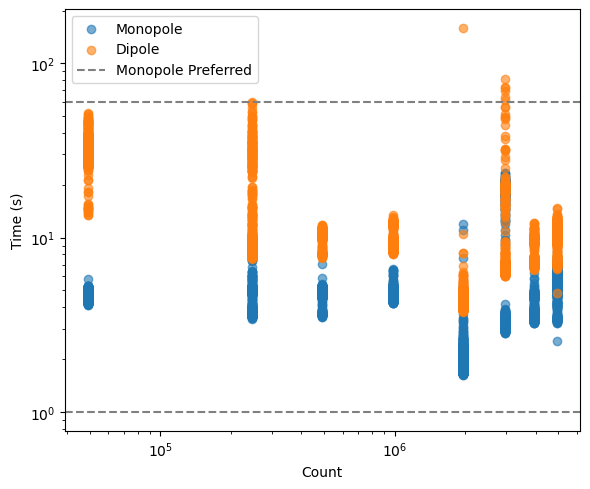

In [407]:
# Split data by model
monopole = all_data[all_data['model'] == 'monopole_model']
dipole = all_data[all_data['model'] == 'dipole_model']

plt.figure(figsize=(6, 5))

# Plot each model with a different color
plt.scatter(monopole['Nbar']*49152, monopole['time'], color='C0', label='Monopole', alpha=0.6)
plt.scatter(dipole['Nbar']*49152, dipole['time'], color='C1', label='Dipole', alpha=0.6)
plt.xlabel('Count')
plt.ylabel('Time (s)')
plt.axhline(1, color='gray', linestyle='--')
plt.axhline(60, color='gray', linestyle='--', label='Monopole Preferred')
plt.legend()
plt.xscale('log')  # Log scale for better visibility
plt.yscale('log')  # Log scale for better visibility
plt.tight_layout()
plt.show()

In [376]:
progress_file = 'masked_progress.json'
with open(progress_file, 'w') as f:
    json.dump({'Nbar_idx': 0, 'i': 6 + 1, 'mask_idx': 7}, f)

In [9]:
def mask_data(NSIDE, m, mask_angle):
    NPIX = hp.nside2npix(NSIDE)
    theta, phi = hp.pix2ang(NSIDE, np.arange(NPIX))
    mask = (theta > np.radians(90 - mask_angle)) & (theta < np.radians(90+mask_angle))
    
    # for plotting
    m_plot = hp.ma(m.copy().astype(float))
    m_plot.mask = mask

    # for fitting, can't use nans need to remove the masked indices. Also need fit_mask to mask in likelihood too
    m_fit = m.copy()
    fit_mask = ~mask
    m_fit = m[fit_mask]

    return m_plot, m_fit, fit_mask

In [27]:
NSIDE=64
npix = hp.nside2npix(NSIDE)
dipole_theta = np.radians(48)
dipole_phi = -np.radians(96)
m, lambdas = dipole_sampling(NSIDE, 203.5, 0.007, dipole_theta, dipole_phi)


theta, phi = hp.pix2ang(NSIDE, np.arange(npix))

mask_angles = [0,10,20,30,40,50,60,70,80]
for mask_angle in mask_angles:
    m_plot_masked, m_fit, fit_mask = mask_data(NSIDE, m, mask_angle)
    mask = (theta > np.radians(90 - mask_angle)) & (theta < np.radians(90+mask_angle))

    # # for plotting, need to use nans
    m_plot_masked = hp.ma(m.copy().astype(float))
    m_plot_masked.mask = mask

    # Set the masked values to be gray for plotting
    cmap = plt.get_cmap('plasma').copy()
    cmap.set_bad('gray')

    # for fitting, can't use nans need to remove the masked indices. Also need fit_mask to mask in likelihood too
    m_fit = m.copy()
    fit_mask = ~mask
    m_fit = m[fit_mask] 
    #print to 2 dp
    print(f"{len(m_fit)/49152:.4f}", f"{len(m_fit)/49152*10000000:.0f}")


    plt.show()



1.0000 10000000
0.8281 8281250
0.6615 6614583
0.5052 5052083
0.3594 3593750
0.2329 2329102
0.1335 1334635
0.0615 615234
0.0148 148112
